# Porosity prediction using Python and Random forest 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!git clone https://github.com/otavioon/d2geo.git
!pip install lasio
!pip install segyio

fatal: destination path 'd2geo' already exists and is not an empty directory.


## Import required libraries & dataset





In [3]:
#@title Import relevant libraries
import numpy as np
import pandas as pd
#import tensorflow as tf
#from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns

import time

import lasio
import segyio

from sklearn.model_selection import train_test_split,learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

#%tensorflow_version 2.x
#from __future__ import absolute_import, division, print_function, unicode_literals

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 20
pd.options.display.float_format = "{:.2f}".format


font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 32,
        }

print("Imported modules.")

Imported modules.


In [4]:
#title Import dataset
# Porosity in this data are multipied by 100 in order to ensure the scaling
# with other data points 

df = pd.read_csv(f"/content/drive/MyDrive/GeoML-3.0/from_seismic/F02-1_Attributes.csv")

print("Done Importing")

Done Importing


## Data reporting

In [5]:
#@title Display first five rows and data information
display(df.head(5))
display(df.info())

MD  Amp   D1   D2    ENV  ...  POL  RmsAmp  Sweetness  Var  Porosity
0 48.00 0.00 0.00 0.00 143.78  ... 0.11    0.00     143.78 0.00   -999.25
1 48.15 0.00 0.00 0.00 144.71  ... 0.11    0.00     144.71 0.00   -999.25
2 48.30 0.00 0.00 0.00 145.65  ... 0.12    0.00     145.65 0.00   -999.25
3 48.45 0.00 0.00 0.00 146.58  ... 0.12    0.00     146.58 0.00   -999.25
4 48.60 0.00 0.00 0.00 147.52  ... 0.13    0.00     147.52 0.00   -999.25

[5 rows x 12 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9680 entries, 0 to 9679
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MD         9680 non-null   float64
 1   Amp        9680 non-null   float64
 2   D1         9680 non-null   float64
 3   D2         9680 non-null   float64
 4   ENV        9680 non-null   float64
 5   Freq       9680 non-null   float64
 6   Phase      9680 non-null   float64
 7   POL        9680 non-null   float64
 8   RmsAmp     9680 non-null   float64
 9   Sweetness  9680 non-null   float64
 10  Var        9680 non-null   float64
 11  Porosity   9680 non-null   float64
dtypes: float64(12)
memory usage: 907.6 KB


None

In [6]:
#@title Display last five rows and data describtion

display(df.tail())
display(df.describe())

MD    Amp     D1     D2  ...  RmsAmp  Sweetness  Var  Porosity
9675 1499.25 570.59 -33.70 179.26  ... 1045.07     228.30 0.44   -999.25
9676 1499.40 569.97 -21.92 163.92  ... 1047.10     227.54 0.44   -999.25
9677 1499.55 569.36 -10.15 148.59  ... 1049.12     226.79 0.44   -999.25
9678 1499.70 563.20   1.63 133.26  ... 1051.15     226.04 0.44   -999.25
9679 1499.85 553.90  13.37 117.96  ... 1053.17     225.29 0.44   -999.25

[5 rows x 12 columns]

MD      Amp       D1        D2  ...  RmsAmp  Sweetness     Var  Porosity
count 9680.00  9680.00  9680.00   9680.00  ... 9680.00    9680.00 9680.00   9680.00
mean   773.92    -3.36     0.06      1.06  ... 2077.43     439.76    0.30   -492.66
std    419.18   777.62  1970.81   2749.69  ...  966.57     256.11    0.19    499.76
min     48.00 -2888.46 -8854.79 -14944.56  ...    0.00      66.56    0.00   -999.25
25%    410.96  -464.44  -921.64  -1303.82  ... 1353.41     253.61    0.13   -999.25
50%    773.92   -19.66     0.00      0.00  ... 1995.58     384.20    0.29      0.23
75%   1136.89   495.14   958.78   1350.26  ... 2447.92     571.24    0.42      0.28
max   1499.85  2759.31 11384.03  13955.13  ... 5236.88    1567.95    0.84      0.71

[8 rows x 12 columns]

In [7]:
df.columns

Index(['MD', 'Amp', 'D1', 'D2', 'ENV', 'Freq', 'Phase', 'POL', 'RmsAmp',
       'Sweetness', 'Var', 'Porosity'],
      dtype='object')

In [8]:
df['Porosity']= df['Porosity']*100
df.describe()

MD      Amp       D1        D2  ...  RmsAmp  Sweetness     Var  Porosity
count 9680.00  9680.00  9680.00   9680.00  ... 9680.00    9680.00 9680.00   9680.00
mean   773.92    -3.36     0.06      1.06  ... 2077.43     439.76    0.30 -49265.76
std    419.18   777.62  1970.81   2749.69  ...  966.57     256.11    0.19  49975.66
min     48.00 -2888.46 -8854.79 -14944.56  ...    0.00      66.56    0.00 -99925.00
25%    410.96  -464.44  -921.64  -1303.82  ... 1353.41     253.61    0.13 -99925.00
50%    773.92   -19.66     0.00      0.00  ... 1995.58     384.20    0.29     22.65
75%   1136.89   495.14   958.78   1350.26  ... 2447.92     571.24    0.42     28.43
max   1499.85  2759.31 11384.03  13955.13  ... 5236.88    1567.95    0.84     70.90

[8 rows x 12 columns]

In [9]:
df[df==-99925.00]=np.nan
df.describe()

MD      Amp       D1        D2  ...  RmsAmp  Sweetness     Var  Porosity
count 9680.00  9680.00  9680.00   9680.00  ... 9680.00    9680.00 9680.00   4906.00
mean   773.92    -3.36     0.06      1.06  ... 2077.43     439.76    0.30     30.45
std    419.18   777.62  1970.81   2749.69  ...  966.57     256.11    0.19      6.43
min     48.00 -2888.46 -8854.79 -14944.56  ...    0.00      66.56    0.00     20.39
25%    410.96  -464.44  -921.64  -1303.82  ... 1353.41     253.61    0.13     25.79
50%    773.92   -19.66     0.00      0.00  ... 1995.58     384.20    0.29     28.30
75%   1136.89   495.14   958.78   1350.26  ... 2447.92     571.24    0.42     33.98
max   1499.85  2759.31 11384.03  13955.13  ... 5236.88    1567.95    0.84     70.90

[8 rows x 12 columns]

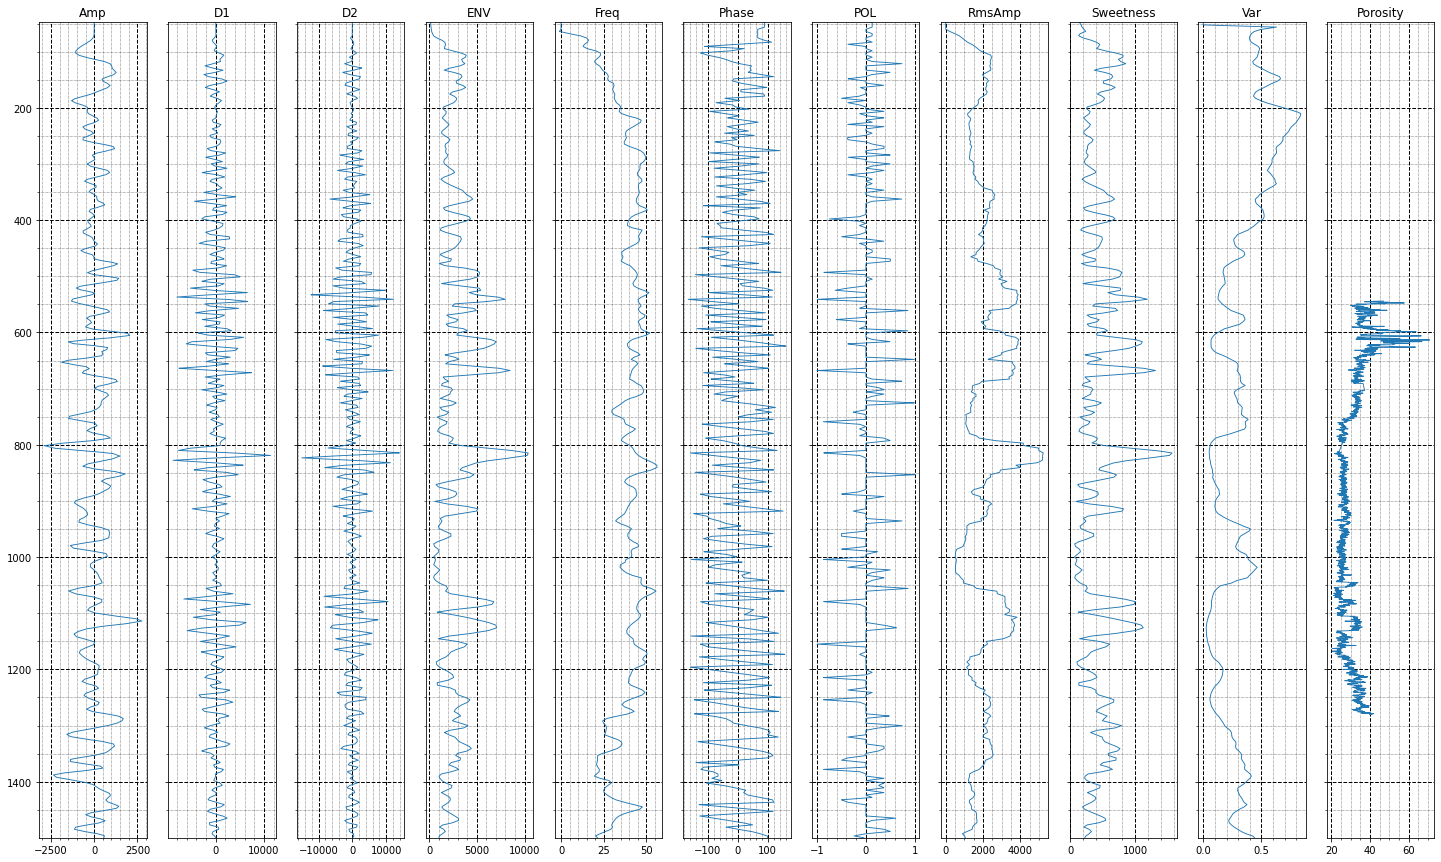

In [10]:
rows, cols = 1,len(df.columns)-1
fig,ax = plt.subplots(nrows=rows, ncols=cols, figsize=(25,15), sharey=True)
names = [ 'MD','Amp', 'D1', 'D2', 'ENV', 'Freq', 'Phase', 'POL', 'RmsAmp',
       'Sweetness', 'Var', 'Porosity']
for i in range(cols):
    ax[i].plot(df.iloc[:,i+1], df.iloc[:,0],linewidth='0.9')
    ax[i].set_ylim(max(df.iloc[:, 0]), min(df.iloc[:, 0]))
    ax[i].minorticks_on()
    ax[i].grid(which='major', linestyle='dashed', linewidth='1', color='black')
    ax[i].grid(which='minor', linestyle=':', linewidth='0.5', color='black') #this is a comment
    ax[i].set_title('%s' %names[i+1])

MD              0
Amp             0
D1              0
D2              0
ENV             0
Freq            0
Phase           0
POL             0
RmsAmp          0
Sweetness       0
Var             0
Porosity     4774
dtype: int64

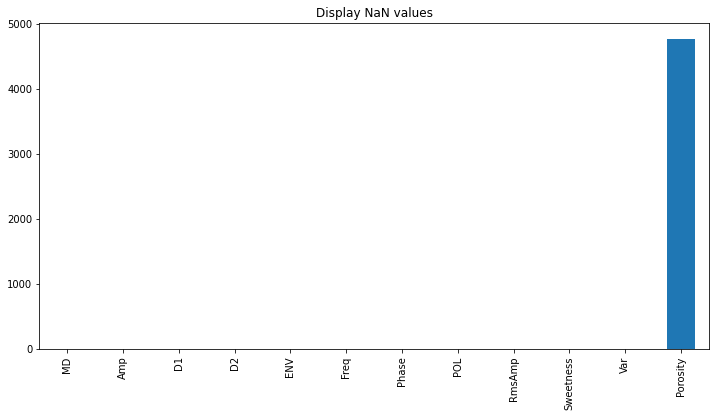

In [11]:
display(df.isna().sum())
# plot NaN Values 
df.isna().sum().plot(kind = 'bar', title = 'Display NaN values', figsize = (12,6));

In [12]:
# Drop Null Value:

df.dropna(inplace=True)
df.isna().sum()

MD           0
Amp          0
D1           0
D2           0
ENV          0
Freq         0
Phase        0
POL          0
RmsAmp       0
Sweetness    0
Var          0
Porosity     0
dtype: int64

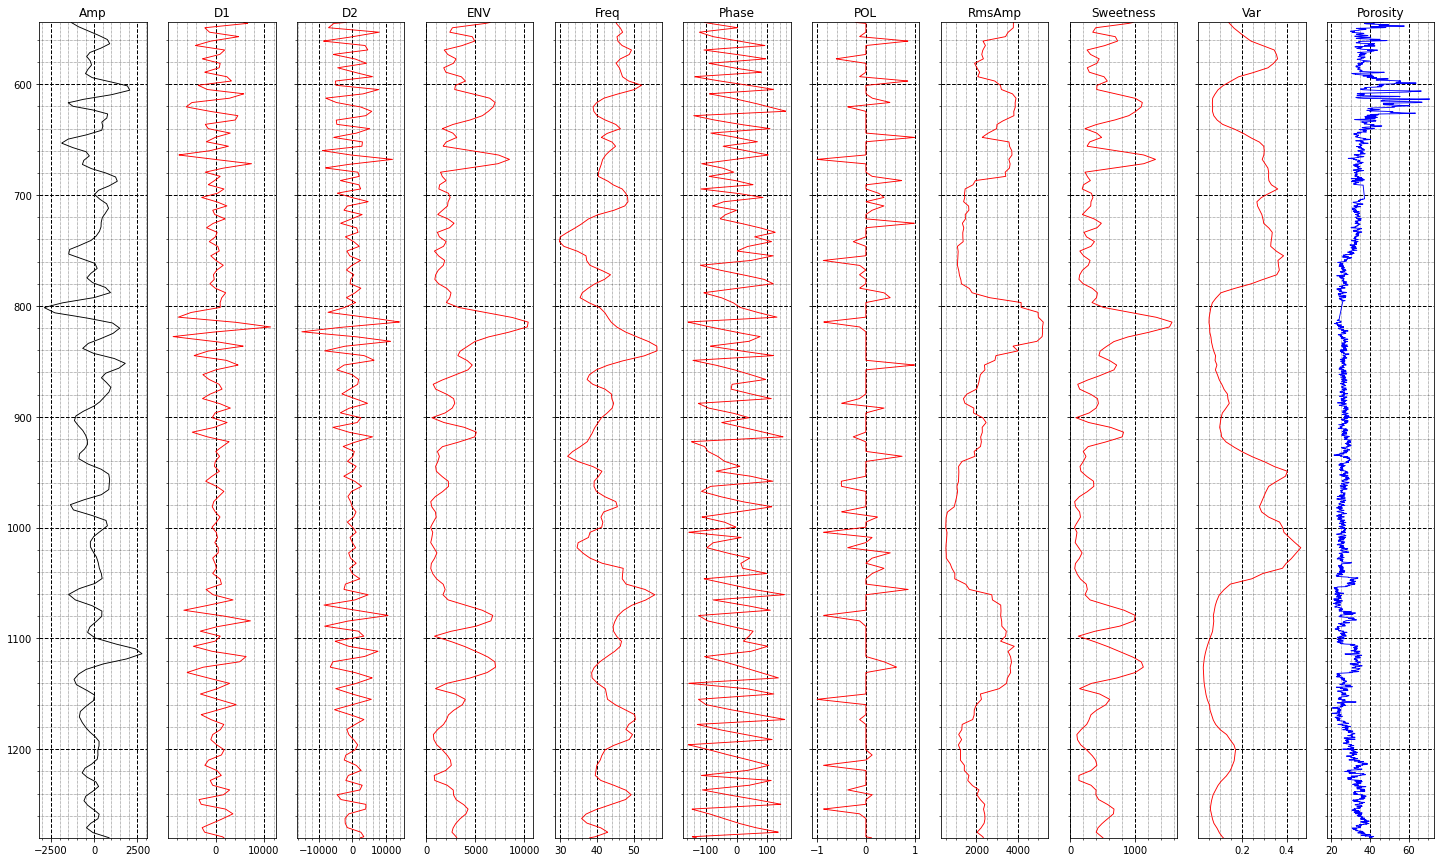

In [13]:
myList = ['black','red','red','red','red','red','red','red','red','red','blue']
rows, cols = 1,11
fig,ax = plt.subplots(nrows=rows, ncols=cols, figsize=(25,15), sharey=True)
names = [ 'Amp', 'D1', 'D2', 'ENV', 'Freq', 'Phase', 'POL', 'RmsAmp',
       'Sweetness', 'Var', 'Porosity']
for i in range(cols):
    ax[i].plot(df.iloc[:,i+1], df.iloc[:,0],linewidth='0.9', c = myList[i])
    ax[i].set_ylim(max(df.iloc[:, 0]), min(df.iloc[:, 0]))
    ax[i].minorticks_on()
    ax[i].grid(which='major', linestyle='dashed', linewidth='1', color='black')
    ax[i].grid(which='minor', linestyle=':', linewidth='0.5', color='black') #this is a comment
    ax[i].set_title('%s' %names[i])

In [14]:
# print data maximum and minimum values along with average
print('Maximum is : ',np.max(df['Porosity']))
print('Minimum is : ',np.min(df['Porosity']))
print('Average is : ',np.average(df['Porosity']))

Maximum is :  70.9
Minimum is :  20.39
Average is :  30.45215654300856


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


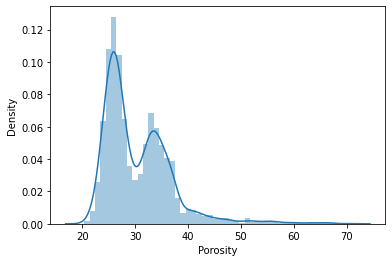

In [15]:
sns.distplot(df['Porosity']);

## Data analysis 

In [16]:
#@title Correlation matrix to show features relationships 
df.corr()

#corr() functions uses pearsman correlation by its default

MD   Amp    D1    D2  ...  RmsAmp  Sweetness   Var  Porosity
MD         1.00 -0.05 -0.02  0.02  ...   -0.24      -0.15 -0.36     -0.40
Amp       -0.05  1.00  0.17  0.11  ...   -0.02       0.11  0.02      0.11
D1        -0.02  0.17  1.00 -0.01  ...   -0.00       0.04 -0.01     -0.00
D2         0.02  0.11 -0.01  1.00  ...   -0.01       0.03 -0.00     -0.05
ENV       -0.15  0.12  0.05  0.03  ...    0.80       1.00 -0.52      0.22
Freq       0.01  0.09 -0.02 -0.00  ...    0.29       0.07 -0.31      0.04
Phase      0.00 -0.17 -0.71 -0.03  ...    0.04      -0.01 -0.06      0.03
POL       -0.16  0.06  0.01 -0.43  ...   -0.00      -0.12 -0.00      0.13
RmsAmp    -0.24 -0.02 -0.00 -0.01  ...    1.00       0.78 -0.63      0.22
Sweetness -0.15  0.11  0.04  0.03  ...    0.78       1.00 -0.51      0.23
Var       -0.36  0.02 -0.01 -0.00  ...   -0.63      -0.51  1.00     -0.02
Porosity  -0.40  0.11 -0.00 -0.05  ...    0.22       0.23 -0.02      1.00

[12 rows x 12 columns]

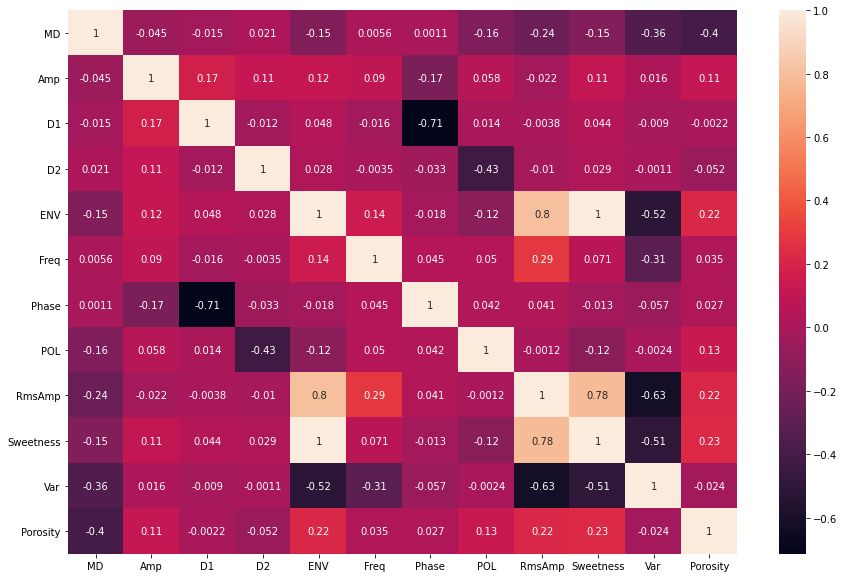

In [17]:
#@title Plot correlation matrix to show relations between features
plt.figure(figsize = (15,10))
sns.heatmap(df.corr(),annot=True)
# try to make annot =  False

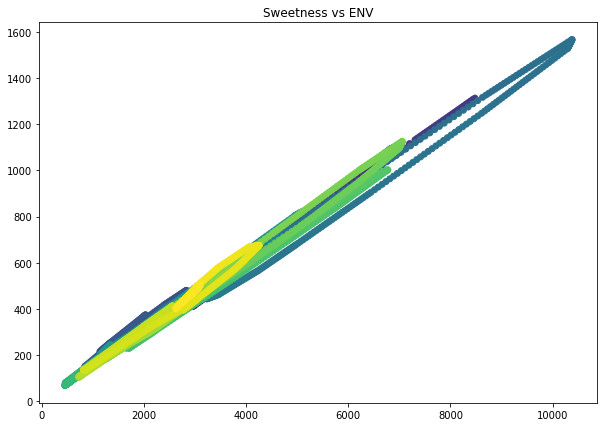

In [18]:
plt.figure(figsize=(10,7))
plt.scatter(df.ENV, df.Sweetness, c = df.MD)
plt.title("Sweetness vs ENV");

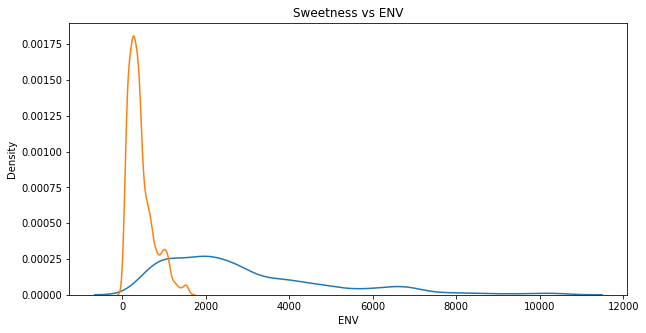

In [115]:
plt.figure(figsize=(10,5))

sns.kdeplot(df['ENV'])
sns.kdeplot(df['Sweetness'])
plt.title("Sweetness vs ENV");

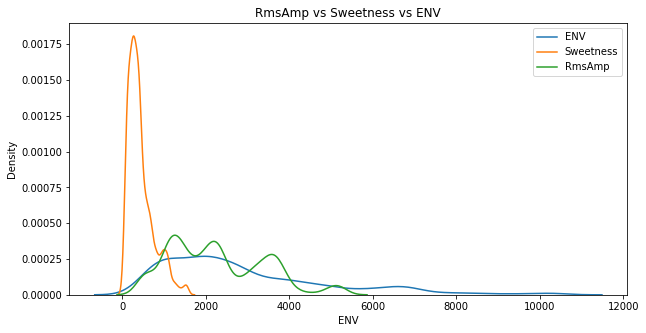

In [114]:
plt.figure(figsize=(10,5))

sns.kdeplot(df['ENV'], label = 'ENV')
sns.kdeplot(df['Sweetness'], label = 'Sweetness')
sns.kdeplot(df['RmsAmp'], label = 'RmsAmp')
plt.legend()
plt.title("RmsAmp vs Sweetness vs ENV");

RMSAMP has been dropped as it is highly correlated with more than one feature that could easily bias the prediction

In [157]:
#title Define dataset and Prediction Yhat

Xdf = df[['Amp', 'D1', 'D2', 'ENV', 'Freq', 'Phase', 'POL',
       'Sweetness', 'Var']]
y = df['Porosity']       

In [158]:
print("Yhat shapes of: ",y.shape)
print("Xdf shapes of: ",Xdf.shape)

Yhat shapes of:  (4906,)
Xdf shapes of:  (4906, 9)


In [159]:
#title Train test split 25%
X_train, X_test, y_train, y_test = train_test_split(Xdf, y, test_size=0.25, random_state=101)

In [160]:
Rfr = RandomForestRegressor(n_estimators=500, min_samples_leaf=3, max_features=1, n_jobs=-1, oob_score=True)

Rfr.fit(X_train,y_train)
y_pred=Rfr.predict(X_test)

In [161]:
Rfr.score(X_test,y_test)*100

89.72034198782495

In [162]:
#title Feature Importance 
%time

feature_imp = pd.Series(Rfr.feature_importances_,index=Xdf.columns).sort_values(ascending=False)
feature_imp

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


Var         0.17
ENV         0.13
Sweetness   0.13
Freq        0.13
Amp         0.12
D2          0.09
D1          0.08
POL         0.08
Phase       0.07
dtype: float64

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


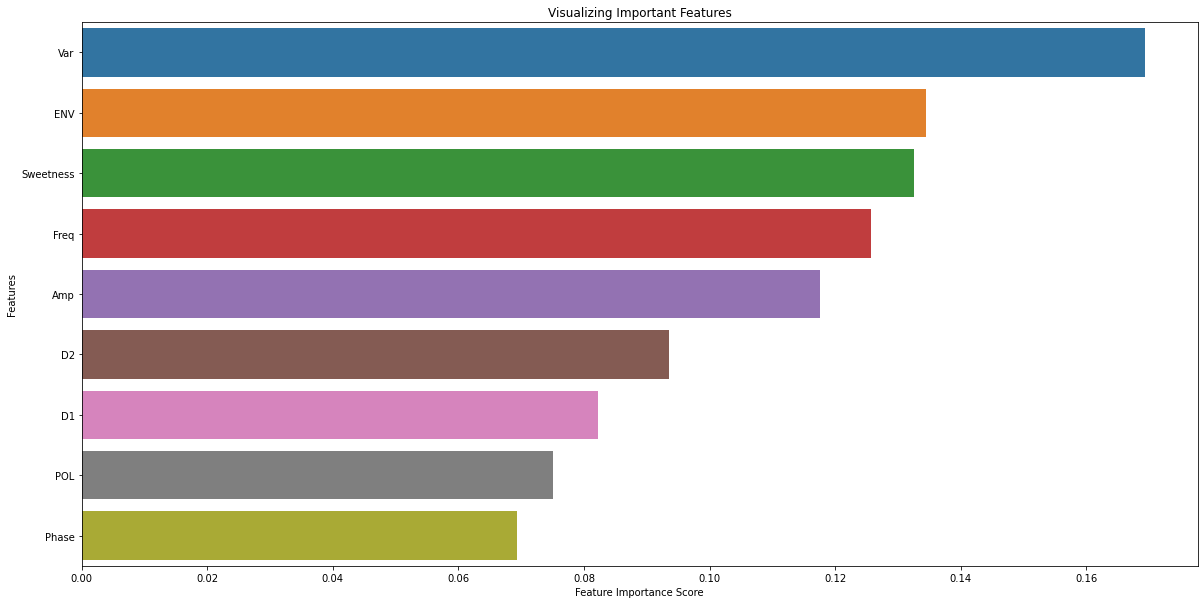

In [163]:
#title  Feature Importance Plotting
%time

plt.figure(figsize=(20,10))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
#plt.legend()
plt.show()

In [164]:
#title Define dataset and Prediction Yhat

X2df = df[['Amp', 'D1', 'D2', 'ENV', 'Freq', 'Phase', 'POL',
       'Sweetness', 'Var']]
y = df['Porosity']       

In [165]:
print("Yhat shapes of: ",y.shape)
print("X2df shapes of: ",X2df.shape)

Yhat shapes of:  (4906,)
X2df shapes of:  (4906, 9)


In [166]:
#title Train test split 25%
X2_train, X2_test, y2_train, y2_test = train_test_split(X2df, y, test_size=0.25, random_state=101)

In [167]:
Rfr2 = RandomForestRegressor(n_estimators=500, min_samples_leaf=3, max_features=1, n_jobs=-1, oob_score=True)

Rfr2.fit(X2_train,y2_train)
y_pred=Rfr2.predict(X2_test)

In [168]:
feature_imp2 = pd.Series(Rfr2.feature_importances_,index=X2df.columns).sort_values(ascending=False)
feature_imp2

Var         0.17
Sweetness   0.14
ENV         0.13
Freq        0.13
Amp         0.11
D2          0.09
D1          0.08
POL         0.08
Phase       0.07
dtype: float64

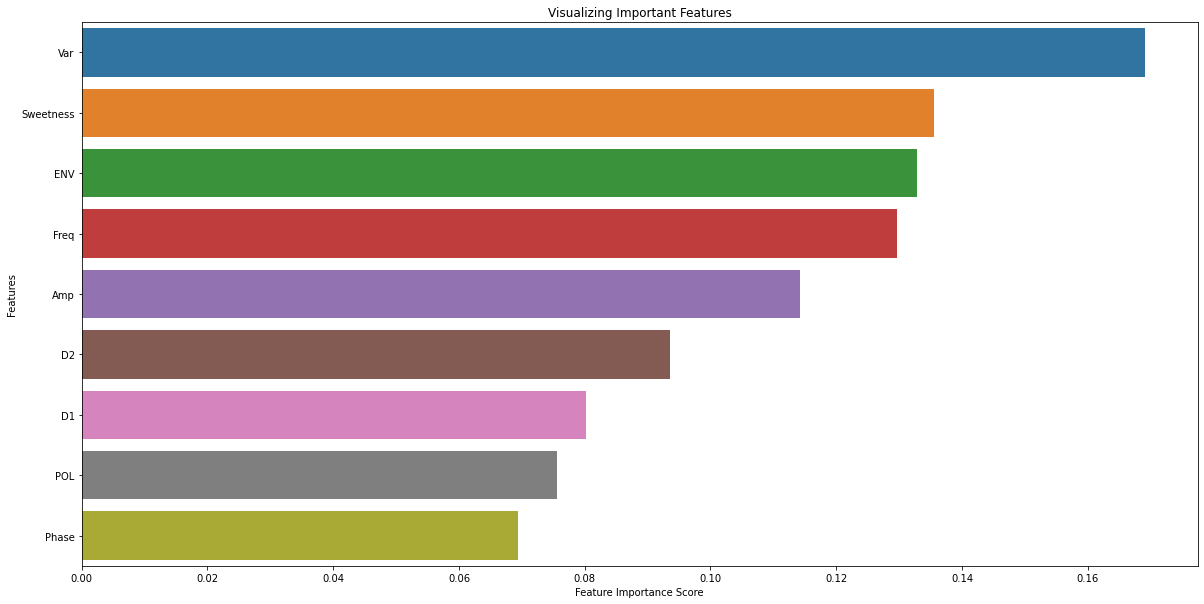

CPU times: user 278 ms, sys: 6.02 ms, total: 284 ms
Wall time: 290 ms


In [169]:
#title  Feature Importance Plotting
%%time

plt.figure(figsize=(20,10))
sns.barplot(x=feature_imp2, y=feature_imp2.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
#plt.legend()
plt.show()

In [170]:
%%time

Rfr = RandomForestRegressor(n_estimators=500, min_samples_leaf=3, max_features=1, n_jobs=-1, oob_score=True)

Rfr.fit(X2_train,y2_train)
y_pred=Rfr.predict(X2_test)

CPU times: user 4.09 s, sys: 133 ms, total: 4.22 s
Wall time: 2.85 s


In [171]:
%%time

Rfr.score(X2_test,y2_test)*100

CPU times: user 215 ms, sys: 29.8 ms, total: 245 ms
Wall time: 209 ms


89.87755570504493

In [172]:
#title Feature Importance 
%%time

feature_imp2 = pd.Series(Rfr.feature_importances_,index=X2df.columns).sort_values(ascending=False)
feature_imp2

CPU times: user 106 ms, sys: 27.3 ms, total: 133 ms
Wall time: 215 ms


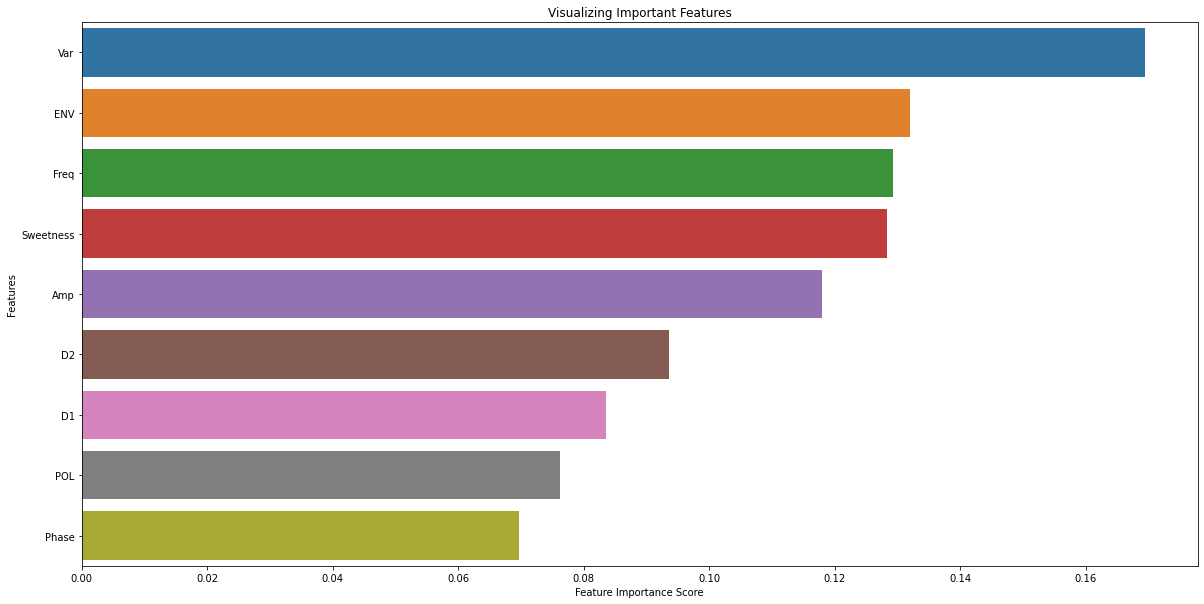

CPU times: user 281 ms, sys: 1.7 ms, total: 282 ms
Wall time: 287 ms


In [173]:
#title  Feature Importance Plotting
%%time

plt.figure(figsize=(20,10))
sns.barplot(x=feature_imp2, y=feature_imp2.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
#plt.legend()
plt.show()

In [174]:
#title Feature importing score
%%time
Rfr.score(X2_train,y2_train)*100

CPU times: user 409 ms, sys: 24.3 ms, total: 434 ms
Wall time: 315 ms


95.80445496447578

10 0.977022402603392
20 0.9785116724210492
30 0.980173628900432
40 0.9805679296074782
50 0.9807143795218685
60 0.9818168280511255
70 0.9804301089549308
80 0.9812632667410511
90 0.981249202271437
100 0.9813679362308247
110 0.9815024885535198
120 0.9816064658888005
130 0.9823602351750186
140 0.9814002567745616
150 0.9812611874497639
160 0.9816099370359841
170 0.9817400849340862
180 0.9820818038255646
190 0.9816049277968137
200 0.9820624362636703
210 0.9815431821019582
220 0.9816317638604684
230 0.9820177967986096
240 0.9821843729444765
250 0.9821370189854862
260 0.9817897153054622
270 0.981892391881946
280 0.9820897204973095
290 0.9819222868066207
CPU times: user 1min 16s, sys: 832 ms, total: 1min 17s
Wall time: 45.6 s


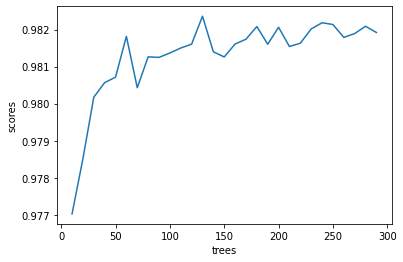

In [175]:
#title Number of trees testing
%%time

scoring = []
trees =[]
for i in range(10,300,10):
  Rfr = RandomForestRegressor(n_estimators=i, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=False)
  Rfr.fit(X2_train,y2_train)
  h = Rfr.score(X2_train,y2_train)
  print(i, h)
  scoring.append(h)
  trees.append(i)
  
plt.plot(trees, scoring)
plt.xlabel("trees")
plt.ylabel("scores")

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


10 0.9749992110813215
20 0.9791386531888905
30 0.9795223995942032
40 0.9806086195058679
50 0.9810328668284867
60 0.9806246830586153
70 0.9812778019107836
80 0.9822196824056213
90 0.9819451951860314
100 0.9817283799341374
110 0.9824525883556033
120 0.9824399750605118
130 0.9820812072093648
140 0.9824985623458621
150 0.9821440529501737
160 0.9824699021729058
170 0.9814841141386385
180 0.9815929118713737
190 0.9823927554983002
200 0.9817240799972389
210 0.9817512078588573
220 0.981812994532299
230 0.981881441092817
240 0.982165066126617
250 0.981828138367057
260 0.9816961588007795
270 0.98207618970963
280 0.9818396300535035
290 0.9822062594152714
CPU times: user 1min 19s, sys: 840 ms, total: 1min 20s
Wall time: 48.4 s


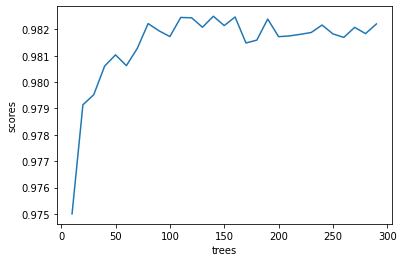

In [176]:
#title Number of Tress testing
%%time

scoring = []
trees =[]
for i in range(10,300,10):
  Rfr = RandomForestRegressor(n_estimators=i, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
  Rfr.fit(X2_train,y2_train)
  h = Rfr.score(X2_train,y2_train)
  print(i, h)
  scoring.append(h)
  trees.append(i)
  
plt.plot(trees, scoring)
plt.xlabel("trees")
plt.ylabel("scores")

In [177]:
#@title OOB score
Rfr.oob_score_

0.9511609843731044

1 0.9953553624029822
2 0.989549115119492
3 0.9808390408191897
4 0.9731140243882267
5 0.9635503403593101
6 0.9529735964256391
7 0.9455398477379852
8 0.9356564447766044
9 0.9310379170013343
CPU times: user 15.4 s, sys: 169 ms, total: 15.6 s
Wall time: 9.59 s


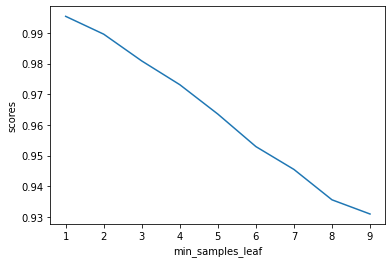

In [178]:
#title Testing minimum sample leaf
%%time

scoring = []
trees =[]
for i in range(1,10,1):
  Rfr = RandomForestRegressor(n_estimators=100, min_samples_leaf=i, max_features=0.5, n_jobs=-1, oob_score=False)
  Rfr.fit(X2_train,y2_train)
  h = Rfr.score(X2_train,y2_train)
  print(i, h)
  scoring.append(h)
  trees.append(i)
  
plt.plot(trees, scoring)
plt.xlabel("min_samples_leaf")
plt.ylabel("scores")

1 0.9916316270952606
2 0.9920748529183951
3 0.9945774226326298
4 0.9950590821631833
5 0.9954561822425881
6 0.9957352328903726
7 0.9956772577139991
8 0.9957719584849456
9 0.9956554839374627
CPU times: user 20.3 s, sys: 197 ms, total: 20.5 s
Wall time: 12.3 s


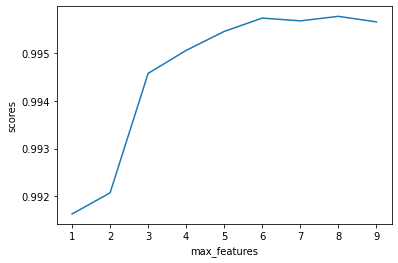

In [179]:
#title testing Maximum features 
%%time

scoring = []
trees =[]
for i in range(1,10,1):
  Rfr = RandomForestRegressor(n_estimators=100,
                              min_samples_leaf=1,
                              max_features=i/10,
                              n_jobs=-1,
                              oob_score=True)
  
  Rfr.fit(X2_train,y2_train)
  h = Rfr.score(X2_train,y2_train)
  print(i, h)
  scoring.append(h)
  trees.append(i)
plt.plot(trees, scoring)
plt.xlabel("max_features")
plt.ylabel("scores")

In [180]:
#@title Building the random forest model
Rfr = RandomForestRegressor(n_estimators=100,
                            min_samples_leaf=3,
                            max_features='auto',
                            n_jobs=-1,
                            oob_score=True)
Rfr.fit(X2_train,y2_train)
Rfr.score(X2_test,y2_test)
#

0.9491410423091948

In [181]:
#@title Estimating Errors
#%time
y_pred=Rfr.predict(X2_test)
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y2_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y2_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y2_test, y_pred)))

Mean Absolute Error: 0.9212262500777332
Mean Squared Error: 2.1475479581991754
Root Mean Squared Error: 1.465451452010327


In [182]:
#@title Building the random forest model
Rfr2 = RandomForestRegressor(n_estimators=100,
                            min_samples_leaf=5,
                            max_features='auto',
                            n_jobs=-1,
                            oob_score=True)
Rfr2.fit(X2_train,y2_train)
Rfr2.score(X2_test,y2_test)
#

0.9323240717194052

In [183]:
#@title Estimating Errors
#%time
y2_pred=Rfr.predict(X2_test)
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y2_test, y2_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y2_test, y2_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y2_test, y2_pred)))

Mean Absolute Error: 0.921226250077733
Mean Squared Error: 2.1475479581991754
Root Mean Squared Error: 1.465451452010327


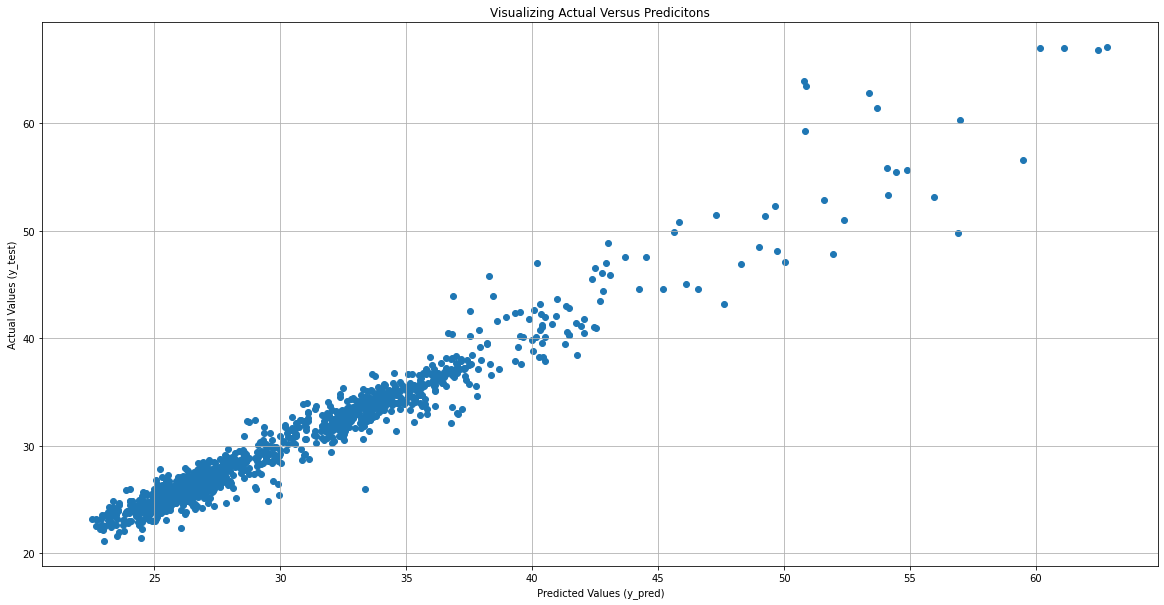

In [184]:
#@title Plotting Actual versus Predicted 
#%%time
plt.figure(figsize=(20,10))
plt.scatter(y2_pred, y2_test)
plt.xlabel(" Predicted Values (y_pred)")
plt.ylabel("Actual Values (y_test)")
plt.title("Visualizing Actual Versus Predicitons")
plt.grid()

In [185]:
#title Testing  Predicted vs Actual
print("Predicted Porosity mean is :", np.mean(y2_pred).round(2), "Predicted Porosity SD is :", np.std(y2_pred).round(2))
print("Actual Porosity mean is :", np.mean(y2_test), "Actual Porosity SD is :", np.std(y2_test))

Predicted Porosity mean is : 30.41 Predicted Porosity SD is : 5.98
Actual Porosity mean is : 30.42484922575386 Actual Porosity SD is : 6.498119710931242


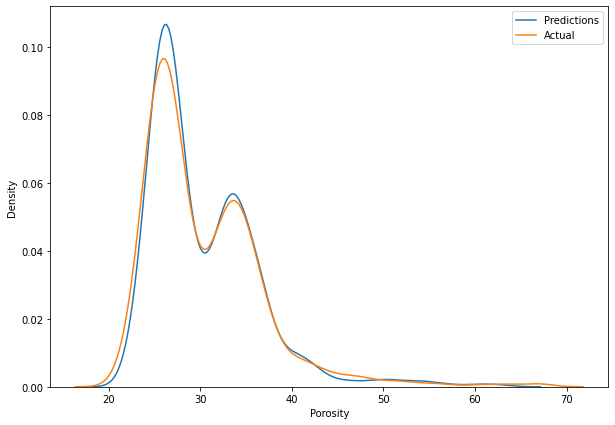

In [186]:
#%%time
plt.figure(figsize=(10,7))

sns.kdeplot(y_pred)
sns.kdeplot(y2_test)
plt.legend(['Predictions', 'Actual'])
plt.show()

In [187]:
test_pred = pd.DataFrame(y_pred,y2_test, columns=['y2_test'])
corre = test_pred.corr()
print("Test-prediction correlations is :", corre.iloc[0,0])


Test-prediction correlations is : 1.0


In [188]:
test_pred.sample(15)


y2_test
Porosity         
26.15       27.59
23.80       24.62
33.09       32.85
42.47       39.51
27.79       25.22
45.06       46.12
35.06       34.76
39.43       41.32
26.98       27.49
35.10       33.90
26.19       25.55
35.61       34.11
29.42       29.06
27.87       27.47
29.09       28.56

In [189]:
pPorosity =Rfr.predict(X2df)

In [190]:
pPorosity

array([40.18211927, 40.50571927, 40.92867729, ..., 38.90732484,
       36.83473587, 36.24021663])

In [191]:
X2df['pPorosity'] = pPorosity

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [192]:
X2df['yPorosity']= y
MD = df['MD']
X2df['Depth'] = MD
display(X2df.columns)
X2df.set_index('Depth')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Index(['Amp', 'D1', 'D2', 'ENV', 'Freq', 'Phase', 'POL', 'Sweetness', 'Var',
       'pPorosity', 'yPorosity', 'Depth'],
      dtype='object')

Amp      D1       D2     ENV  ...  Sweetness  Var  pPorosity  yPorosity
Depth                                      ...                                      
544.20  -1321.62 5799.72 -1788.58 6498.68  ...     967.96 0.14      40.18      47.02
544.35  -1318.45 5963.96 -2455.24 6428.07  ...     957.49 0.14      40.51      43.75
544.50  -1302.61 6128.20 -3121.90 6357.46  ...     947.03 0.14      40.93      42.62
544.65  -1286.76 6292.43 -3788.56 6286.84  ...     936.57 0.14      40.98      41.59
544.80  -1270.92 6456.66 -4455.15 6216.24  ...     926.10 0.14      41.34      42.23
...          ...     ...      ...     ...  ...        ...  ...        ...        ...
1279.35   758.79 1496.33  3025.06 3072.22  ...     492.11 0.11      40.35      40.98
1279.50   784.44 1545.13  2861.13 3080.94  ...     495.27 0.11      39.83      41.17
1279.65   810.08 1593.92  2697.24 3089.66  ...     498.42 0.11      38.91      39.96
1279.80   835.72 1642.58  2533.79 3098.35  ...     501.56 0.11      36.83      40.41
1279.95   861.20 1691.23  2370.35 3107.05  ...     504.71 0.12      36.24      40.83

[4906 rows x 11 columns]

In [193]:
X2df.describe()

Amp       D1        D2  ...  pPorosity  yPorosity   Depth
count  4906.00  4906.00   4906.00  ...    4906.00    4906.00 4906.00
mean    -12.43     6.01    -19.11  ...      30.44      30.45  912.08
std     817.21  2353.09   3298.36  ...       6.08       6.43  212.46
min   -2888.46 -8854.79 -14944.56  ...      21.87      20.39  544.20
25%    -507.95 -1139.88  -1771.26  ...      25.94      25.79  728.14
50%     -13.52     7.08    -41.36  ...      28.18      28.30  912.08
75%     464.96  1105.53   1795.25  ...      33.97      33.98 1096.01
max    2759.31 11384.03  13955.13  ...      63.49      70.90 1279.95

[8 rows x 12 columns]

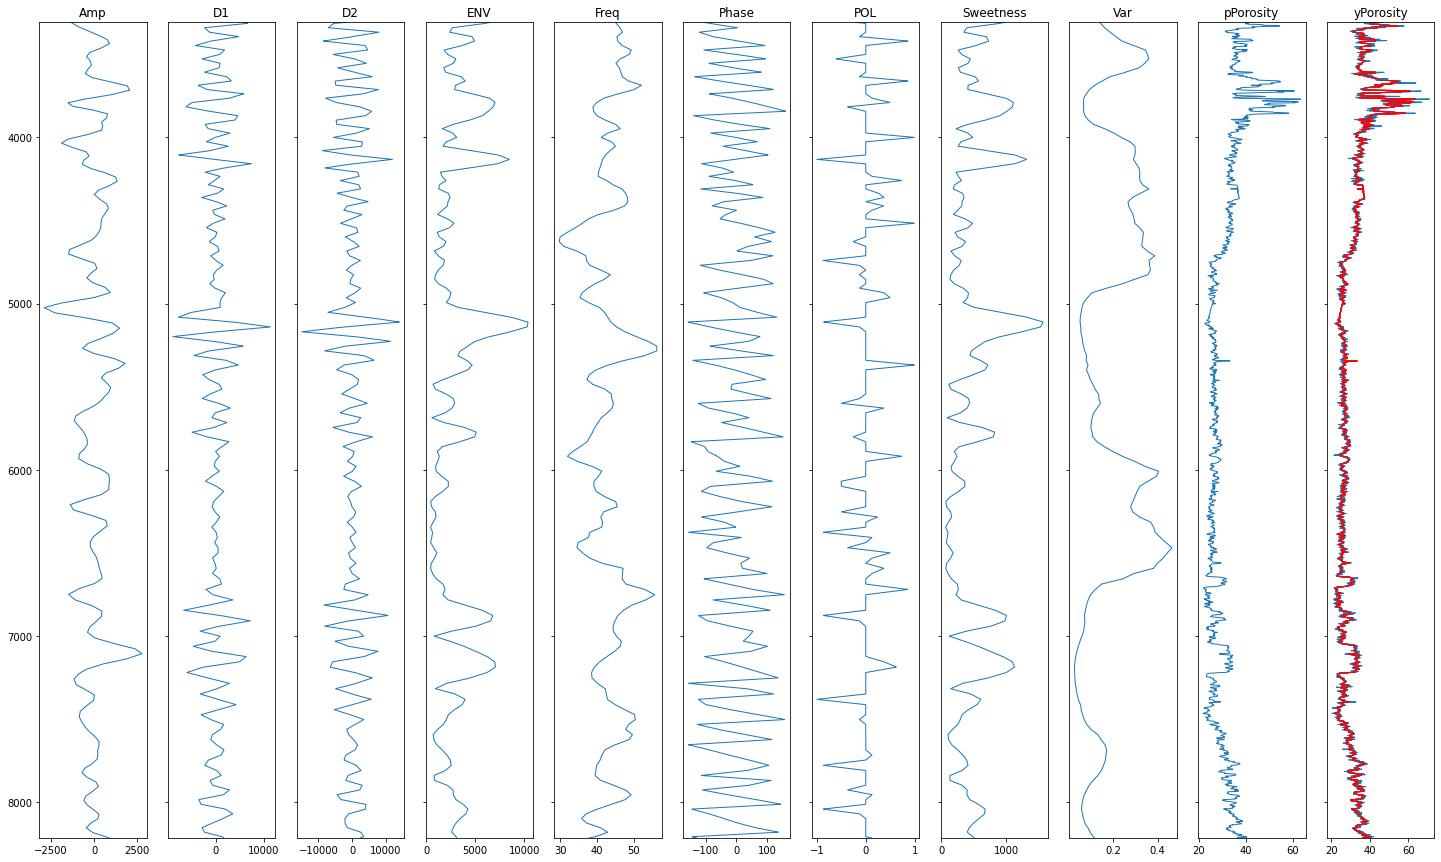

In [195]:
#%%time
rows, cols = 1,len(X2df.columns)-1
fig,ax = plt.subplots(nrows=rows, ncols=cols, figsize=(25,15), sharey=True)
names = X2df.columns
for i in range(cols):
    ax[i].plot(X2df.iloc[:,i], X2df.index,linewidth='1' )
    ax[10].plot(X2df['pPorosity'], X2df.index,linewidth='1', c = 'red')
    ax[i].set_ylim(max(X2df.index), min(X2df.index))
    #ax[i].minorticks_on()
    #ax[i].grid(which='major', linestyle='dashed', linewidth='1', color='black')
    #ax[i].grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    ax[i].set_title('%s' %names[i])

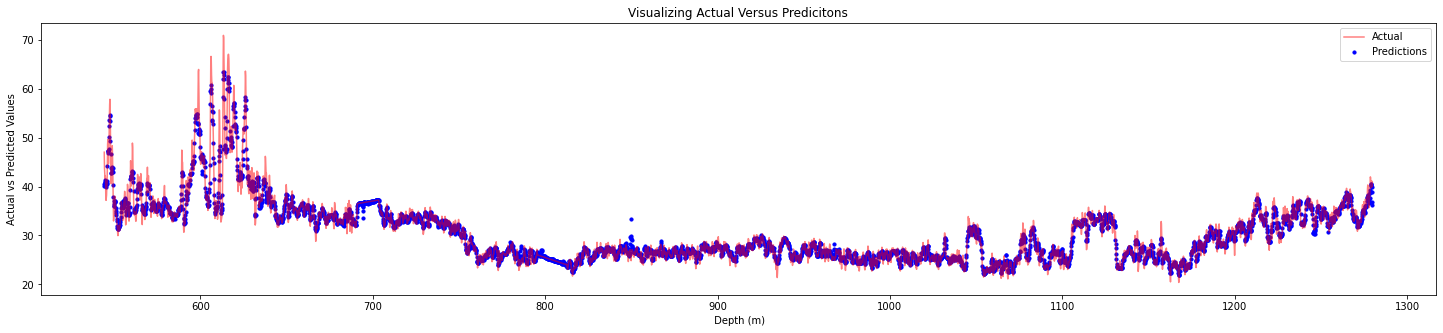

In [196]:
#@title Plotting Actual versus Predicted 
#%%time

plt.figure(figsize=(25,5))
plt.scatter(X2df['Depth'], X2df['pPorosity'], c = 'blue', s = 10, label = 'Predictions' )
plt.plot(X2df['Depth'], X2df['yPorosity'], c = 'red' , alpha=0.5, label = 'Actual')
plt.xlabel(" Depth (m)")
plt.ylabel("Actual vs Predicted Values")
plt.title("Visualizing Actual Versus Predicitons")
#plt.grid()
plt.legend()
plt.show()

#  Real Data Prediction





# Let's do it using Seismic Cube

In [198]:
!pip install "dask[complete]" 

In [199]:
# Dataframe libraries for attribute computation.
import dask.array as da
import dask.dataframe as ddf

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from typing import Dict, List, Tuple, Callable

import segyio

In [200]:
segyfile = f'/content/drive/MyDrive/Public geoscience Data/Dutch F3 seismic data/Dutch Government_F3_entire_8bit seismic.segy'

f = segyio.open(segyfile, xline=segyio.tracefield.TraceField.CDP)

In [201]:
il, xl, t = f.ilines, f.xlines, f.samples
dt = t[1] - t[0]

d = segyio.cube(f)
nil, nxl, nt = d.shape

In [202]:
d.shape

(651, 951, 462)

In [203]:
itmin,itmax = int(t[0]), int(t[-1])
itmin,itmax

(4, 1848)

(300.0, 1250.0, 1848.0, 4.0)

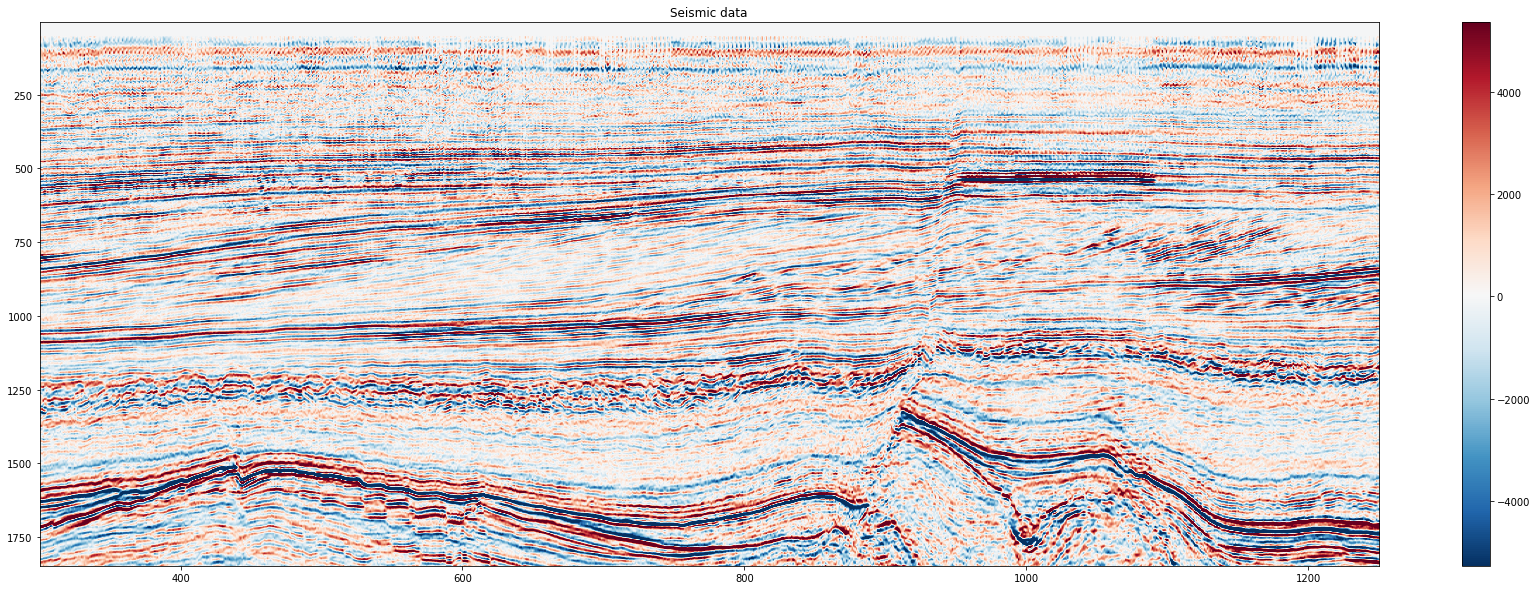

In [204]:
plt.figure(figsize=(30, 10))
plt.imshow(d[nil//4].T, cmap='RdBu_r',
           extent=(xl[0], xl[-1], t[-1], t[0]),
           vmin=np.percentile(d, 2),
           vmax=np.percentile(d, 98))
plt.title('Seismic data')
plt.colorbar()
plt.axis('tight')

In [205]:
def run_attributes(input_cube, attributes: List[Tuple[str, Callable, Dict[str, str]]]):
    datas = [attr_func(input_cube, **attr_kwargs).flatten() for _, attr_func, attr_kwargs in attributes]            
    datas = da.stack(datas, axis=1)
    return ddf.from_dask_array(datas, columns=[attr_name for attr_name, _, _ in attributes])

In [206]:
# Slicing part of the seismic cube to manage the memory and the speed 

Small_cube = d[0:10,:,:]
print('The shape of the new seismic cube is :',Small_cube.shape)
print('The Size of the new seismic cube is :',Small_cube.size)

The shape of the new seismic cube is : (10, 951, 462)
The Size of the new seismic cube is : 4393620


In [207]:
import sys
sys.path.append('./d2geo/attributes')

from d2geo.attributes.CompleTrace import ComplexAttributes
from d2geo.attributes.SignalProcess import SignalProcess
from d2geo.attributes.EdgeDetection import EdgeDetection

complex_att = ComplexAttributes()
signal_process = SignalProcess()
Edge_detection = EdgeDetection()

def amplitude_arr(input_cube):
    return da.from_array(input_cube)

# List of tuples with attribute name, the function 
# to run (with cube as input) and additional kwargs dict.
funcs = [
    ('Amplitude', amplitude_arr, {}),
    ('D1', signal_process.first_derivative, {}),
    ('D2', signal_process.second_derivative, {}),
    ('ENV', complex_att.envelope, {}),
    ('Freq', complex_att.dominant_frequency, {}),
    ('Phase', complex_att.instantaneous_phase, {}),
    ('POL', complex_att.apparent_polarity, {}),
    ('Sweetness', complex_att.sweetness, {}),
    ('Var', Edge_detection.semblance, {}),  
]


In [208]:
dataframe = run_attributes(Small_cube, funcs).compute()
dataframe.sample(5)

Amplitude      D1       D2     ENV  ...  Phase     POL  Sweetness  Var
1322511    1243.00 3722.50  -682.21 4489.70  ... -73.93 4489.70      91.14 0.95
2912475   -1428.00  -64.50   152.88 2014.88  ... 135.13 5444.47     402.98 0.19
1484865    2343.00 1339.50 -1441.41 2934.99  ... -37.03 2934.99      73.33 0.78
4059923    1635.00 1732.00 -1038.55 2286.34  ... -44.35 2526.89      37.72 0.72
1121248    3963.00  355.50  -923.70 4090.38  ... -14.34 4230.38     221.35 0.79

[5 rows x 9 columns]

In [209]:
dataframe.describe()

Amplitude         D1         D2  ...        POL  Sweetness        Var
count 4393620.00 4393620.00 4393620.00  ... 4393620.00 4393620.00 4393620.00
mean       -1.95      -1.01       0.00  ...    -107.80      90.21       0.73
std      2594.97    2131.08    1622.89  ...    5287.53      93.81       0.22
min    -30212.00  -25504.50  -18172.97  ...  -31568.54       0.00       0.00
25%     -1303.00   -1063.50    -737.75  ...   -3579.35      34.97       0.62
50%         0.00       0.00       0.00  ...       0.00      63.95       0.80
75%      1312.00    1061.50     734.60  ...    3626.68     110.95       0.90
max     29844.00   25204.00   17907.65  ...   32547.24    2123.45       1.00

[8 rows x 9 columns]

In [210]:
dataframe.shape

(4393620, 9)

In [211]:
Predicted_Porosity_Cube=Rfr.predict(dataframe)

In [212]:
Predicted_Porosity_Cube

array([27.99368184, 27.99368184, 27.99368184, ..., 30.1121676 ,
       25.05053228, 25.55238571])

In [214]:
Predicted_Porosity_Cube2 = Predicted_Porosity_Cube.reshape(10, 951, 462)

In [215]:
Predicted_Porosity_Cube2.shape

(10, 951, 462)

(300.0, 1250.0, 1848.0, 4.0)

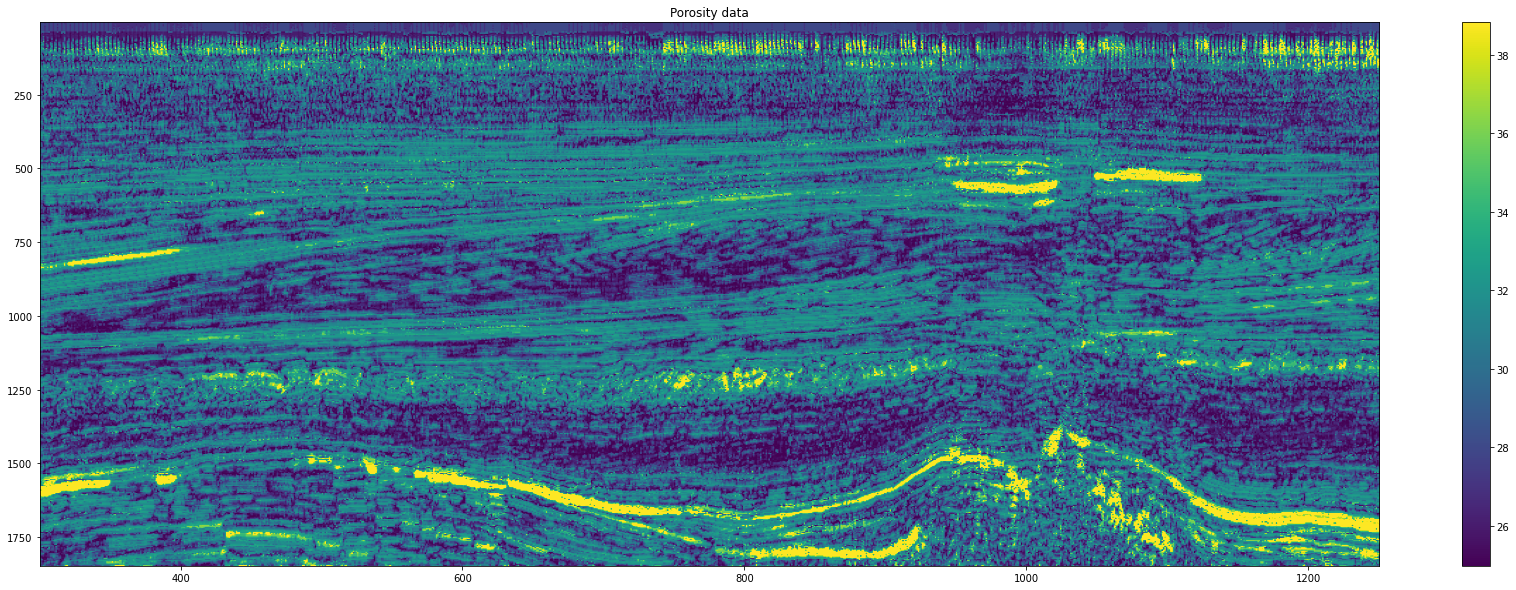

In [224]:
plt.figure(figsize=(30, 10))
plt.imshow(Predicted_Porosity_Cube2[4].T, cmap='viridis',
           extent=(xl[0], xl[-1], t[-1], t[0]),
           vmin=np.percentile(Predicted_Porosity_Cube2, 2),
           vmax=np.percentile(Predicted_Porosity_Cube2, 98))
plt.title('Porosity data')
plt.colorbar()
plt.axis('tight')

In [217]:
### it worked :D :) 
import sys
sys.path.append('./d2geo/attributes')

import h5py
from shutil import copyfile as cf
from d2geo.attributes.io import segy_read, segy_write
output = segy_write(Predicted_Porosity_Cube2, segyfile, "Predicted15_2.segy")

/usr/local/lib/python3.7/dist-packages/segyio/utils.py:23: RuntimeWarning: Implicit conversion from float64 to float32 (narrowing)
  warnings.warn(msg.format(x.dtype, dtype), RuntimeWarning)


## Smoothing version of the porosity

In [218]:
X2df= X2df[X2df['yPorosity'] > 1]

X2df.describe()

Amp       D1        D2  ...  pPorosity  yPorosity   Depth
count  4906.00  4906.00   4906.00  ...    4906.00    4906.00 4906.00
mean    -12.43     6.01    -19.11  ...      30.44      30.45  912.08
std     817.21  2353.09   3298.36  ...       6.08       6.43  212.46
min   -2888.46 -8854.79 -14944.56  ...      21.87      20.39  544.20
25%    -507.95 -1139.88  -1771.26  ...      25.94      25.79  728.14
50%     -13.52     7.08    -41.36  ...      28.18      28.30  912.08
75%     464.96  1105.53   1795.25  ...      33.97      33.98 1096.01
max    2759.31 11384.03  13955.13  ...      63.49      70.90 1279.95

[8 rows x 12 columns]

size 1 , the equavlant Average =  30.45215654300856
size 51 , the equavlant Average =  30.317843456991444
size 101 , the equavlant Average =  30.332354260089687
size 151 , the equavlant Average =  30.248719934773746
size 201 , the equavlant Average =  30.167431716265792
size 251 , the equavlant Average =  30.10822666123115
size 301 , the equavlant Average =  30.059573991031392
size 351 , the equavlant Average =  29.965434162250308
size 401 , the equavlant Average =  29.913410110069304
size 451 , the equavlant Average =  29.88424378312271
size 501 , the equavlant Average =  29.843548715858134
size 551 , the equavlant Average =  29.826249490419897
size 601 , the equavlant Average =  29.82406237260497
size 651 , the equavlant Average =  29.81840399510803
size 701 , the equavlant Average =  29.810222176926214
size 751 , the equavlant Average =  29.803189971463517
size 801 , the equavlant Average =  29.804258051365675
size 851 , the equavlant Average =  29.811235222176922
size 901 , the equ

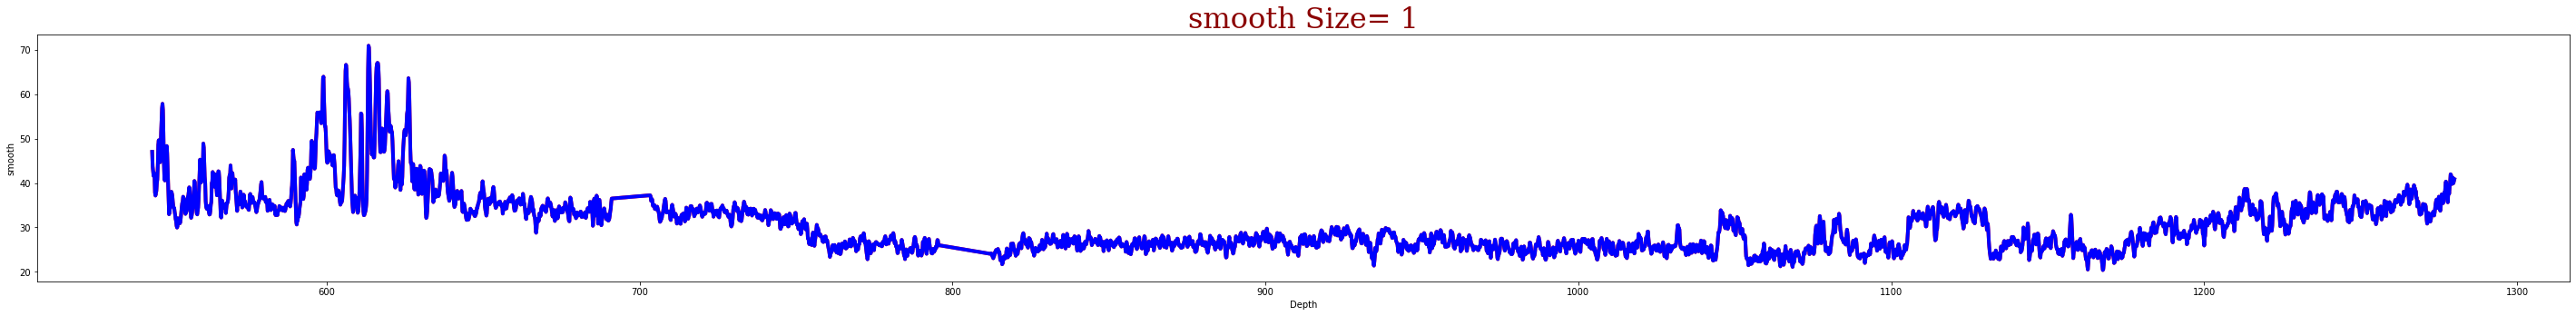

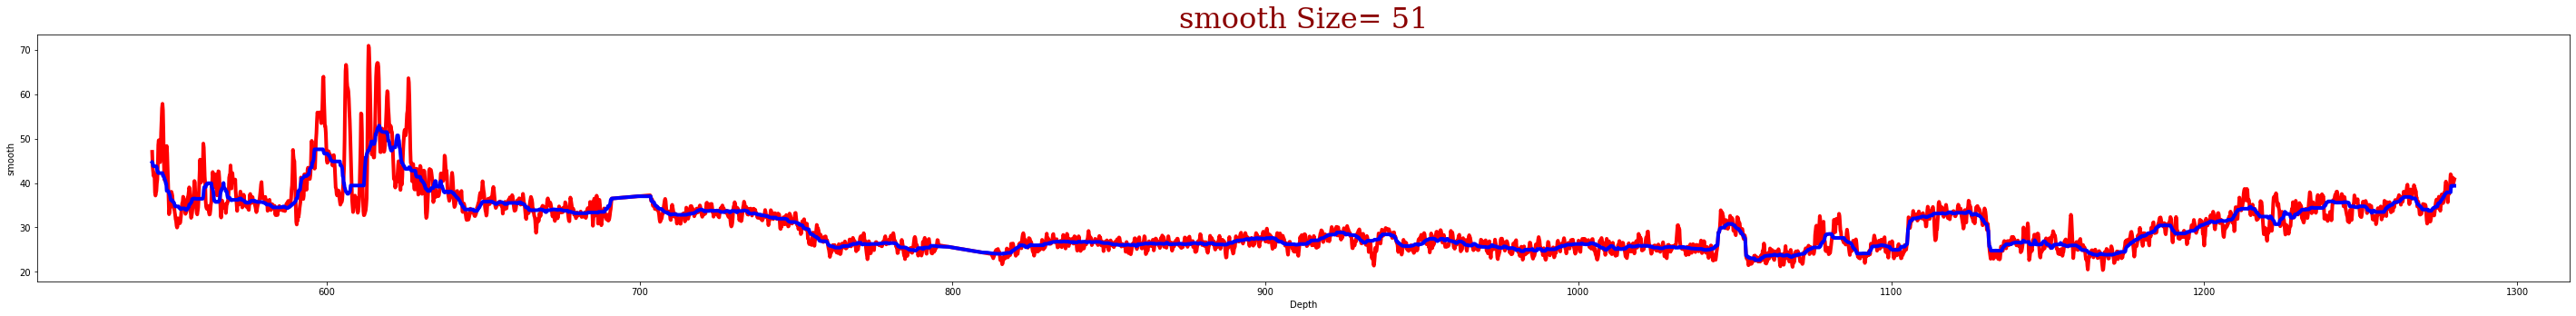

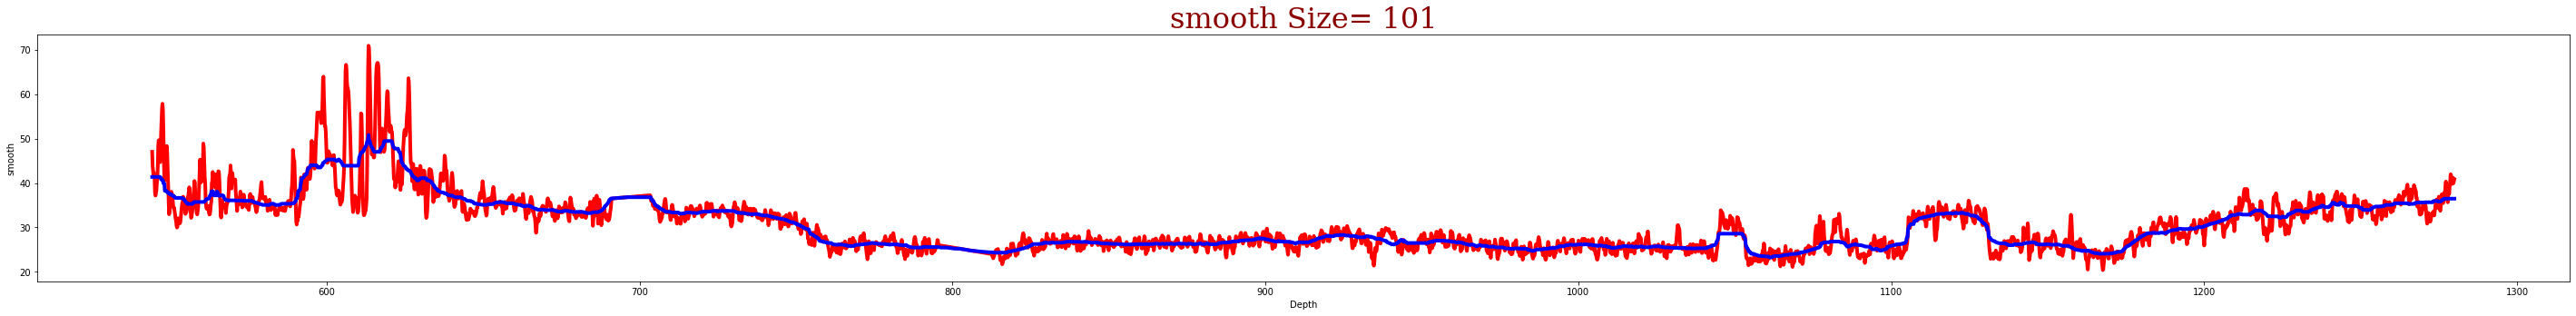

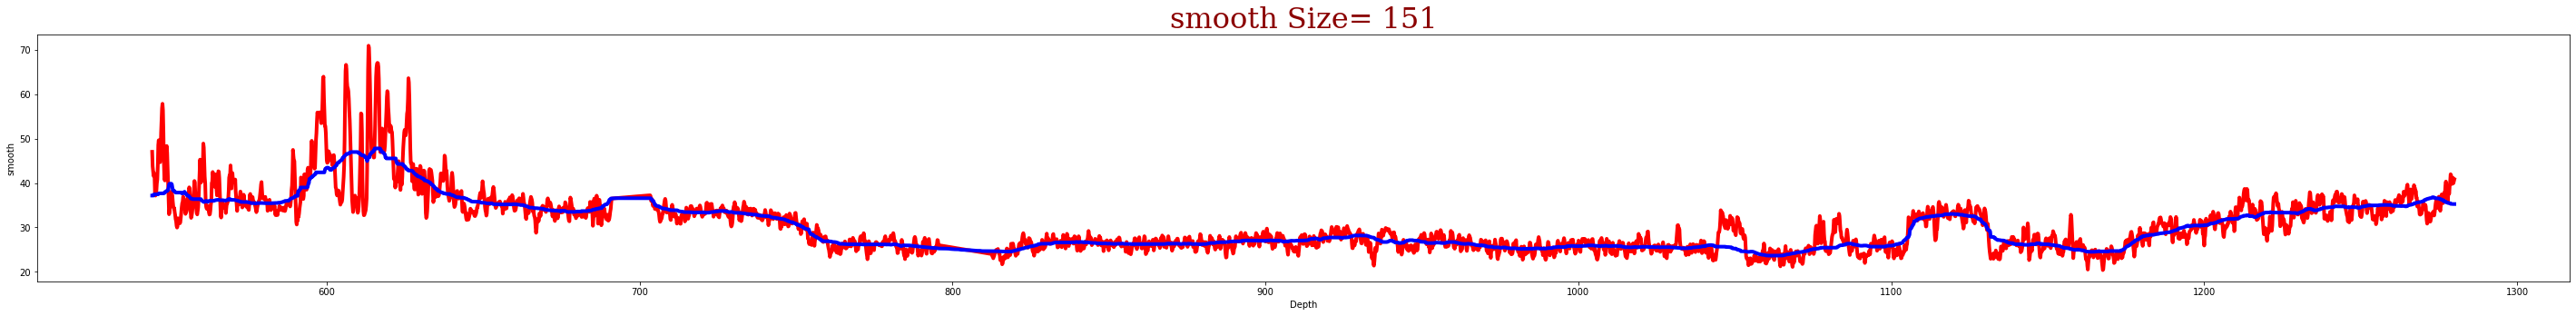

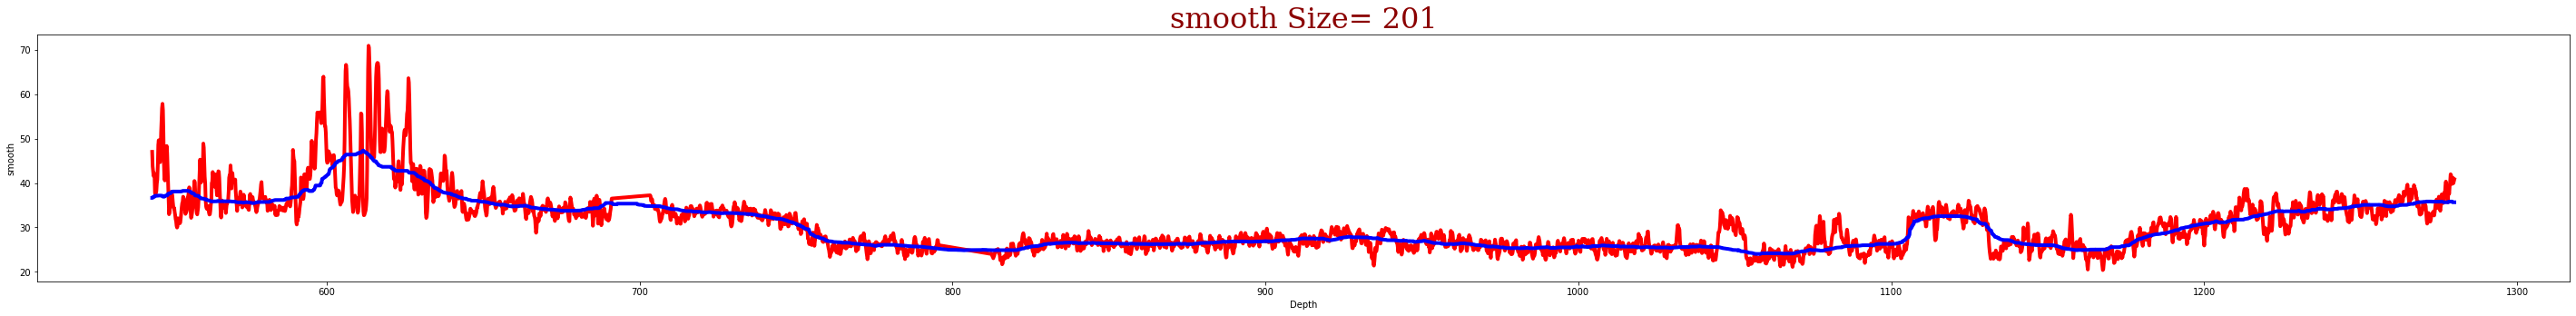

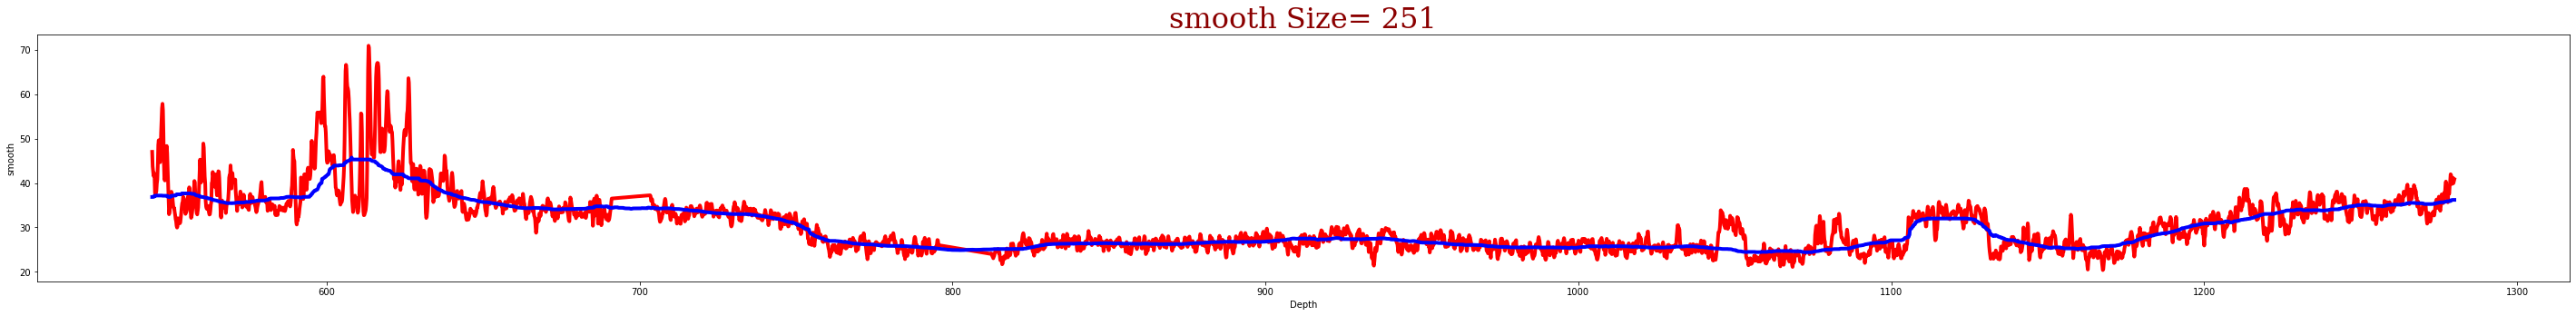

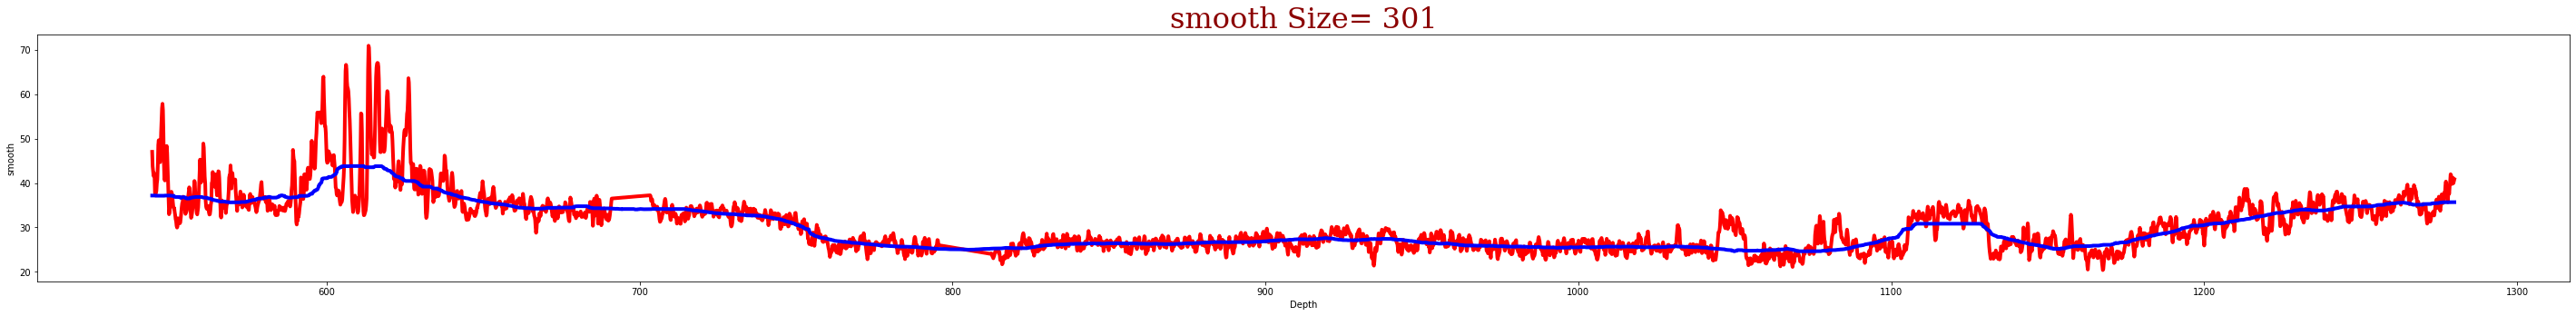

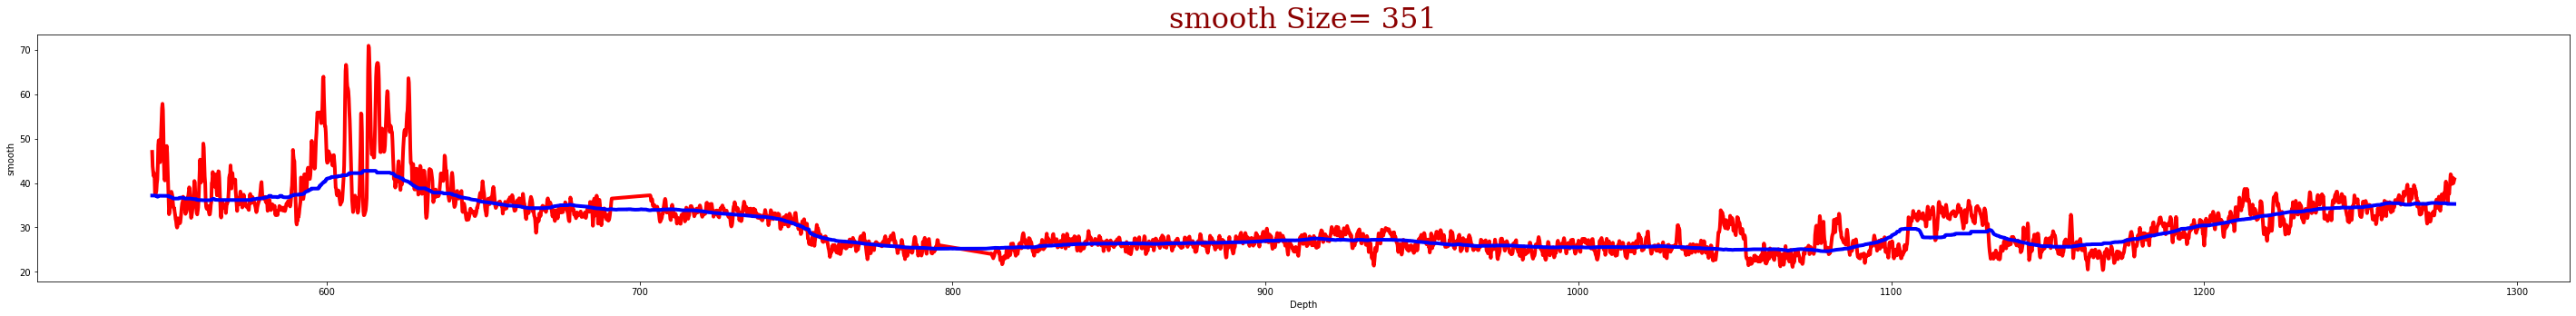

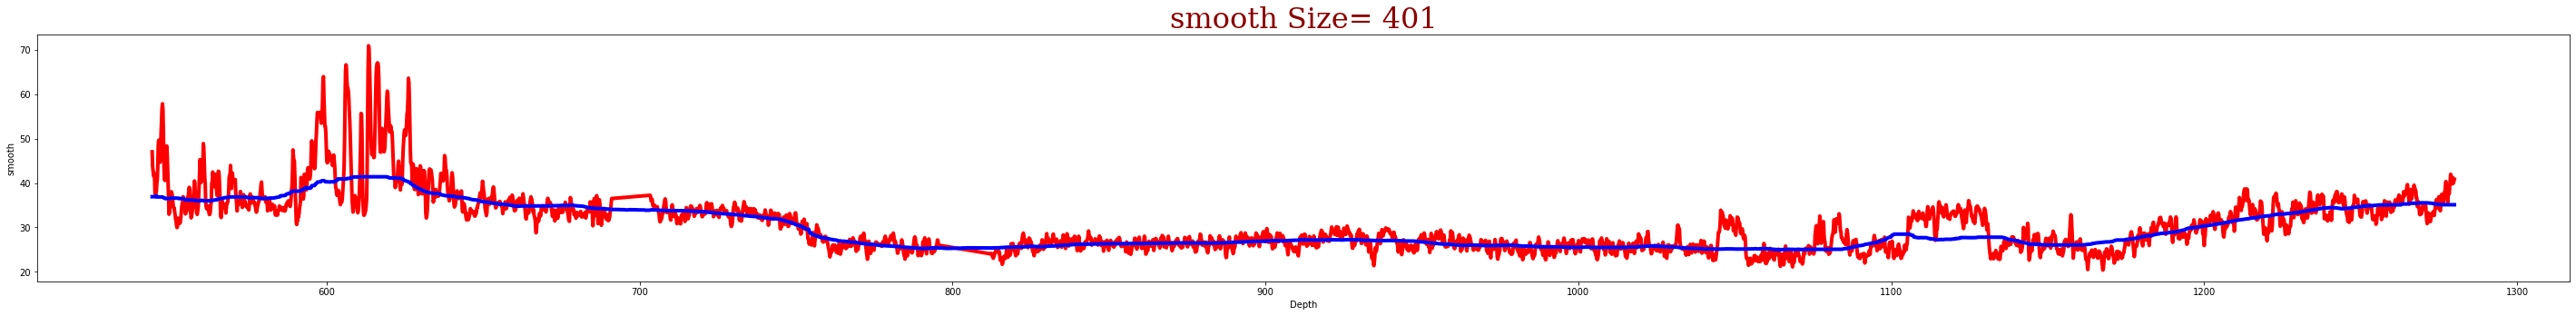

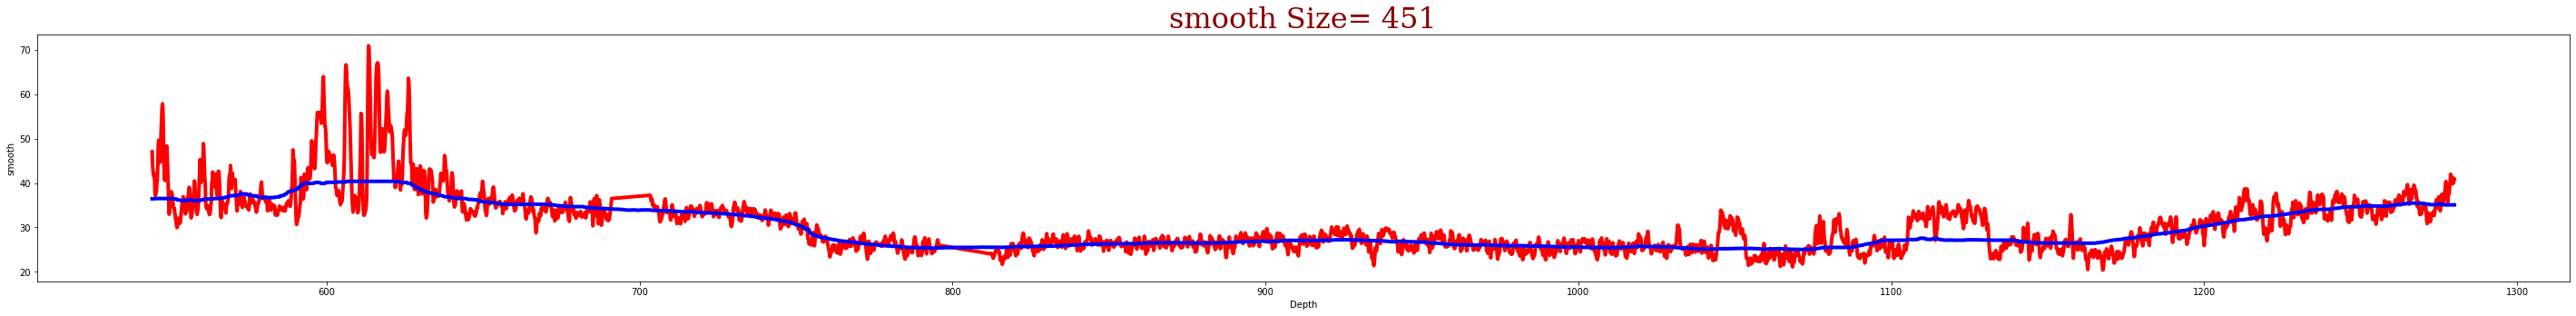

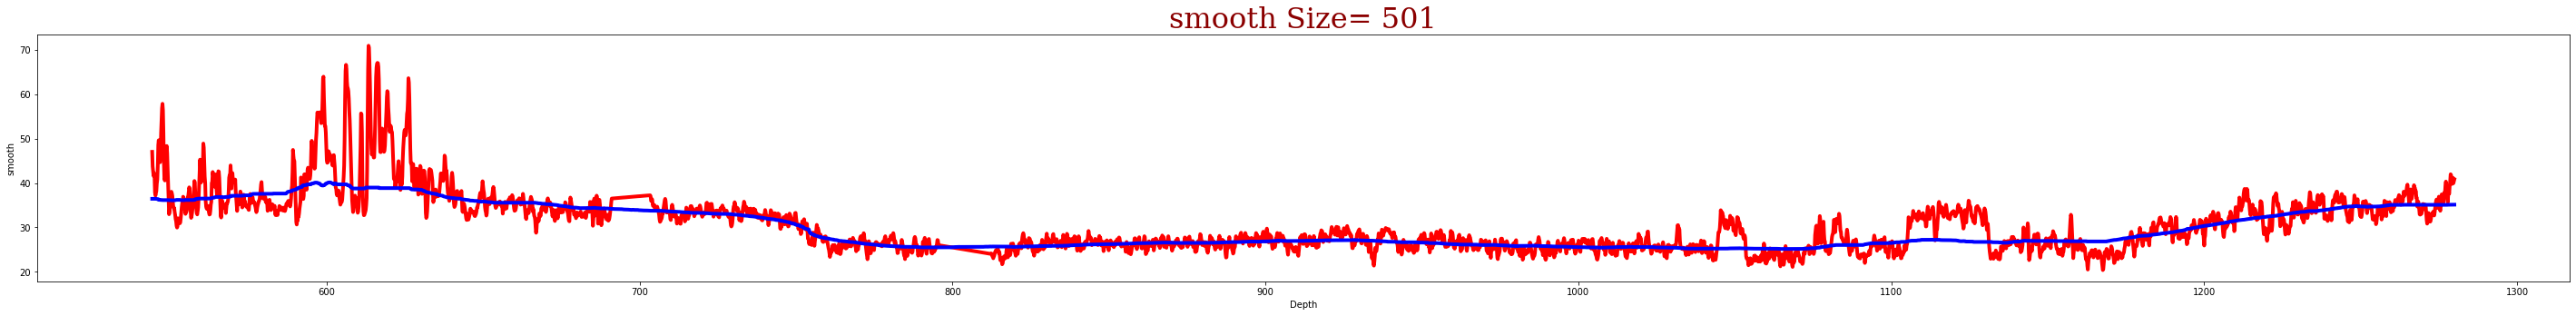

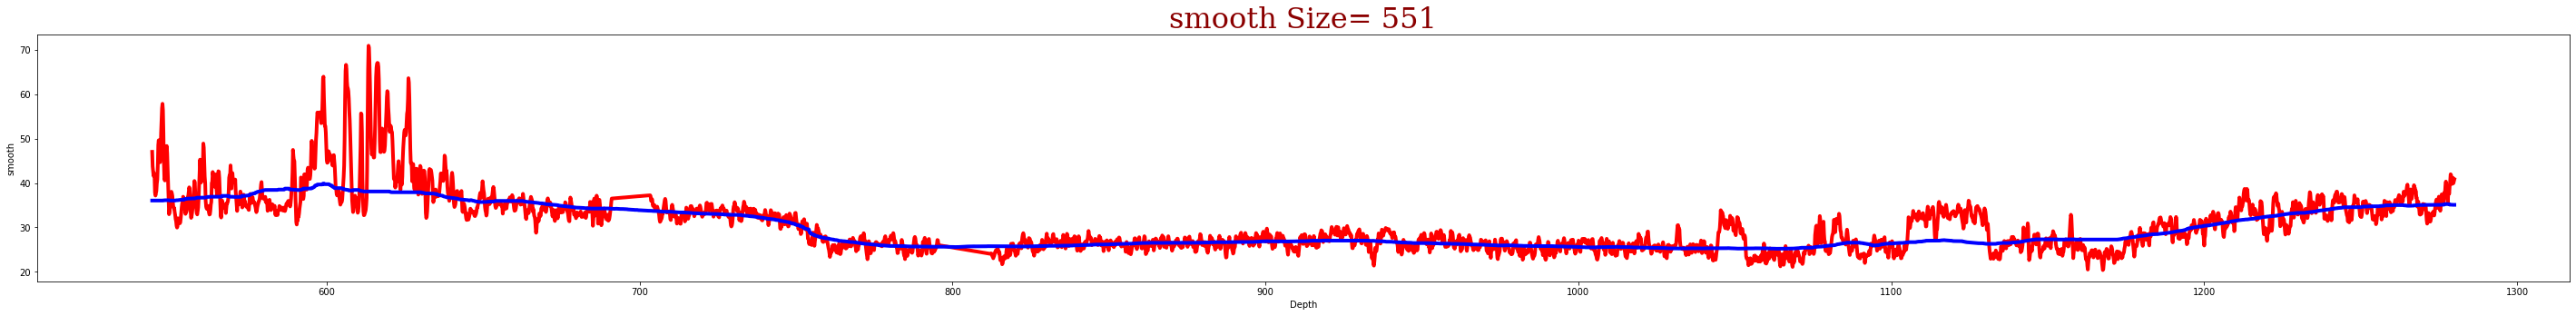

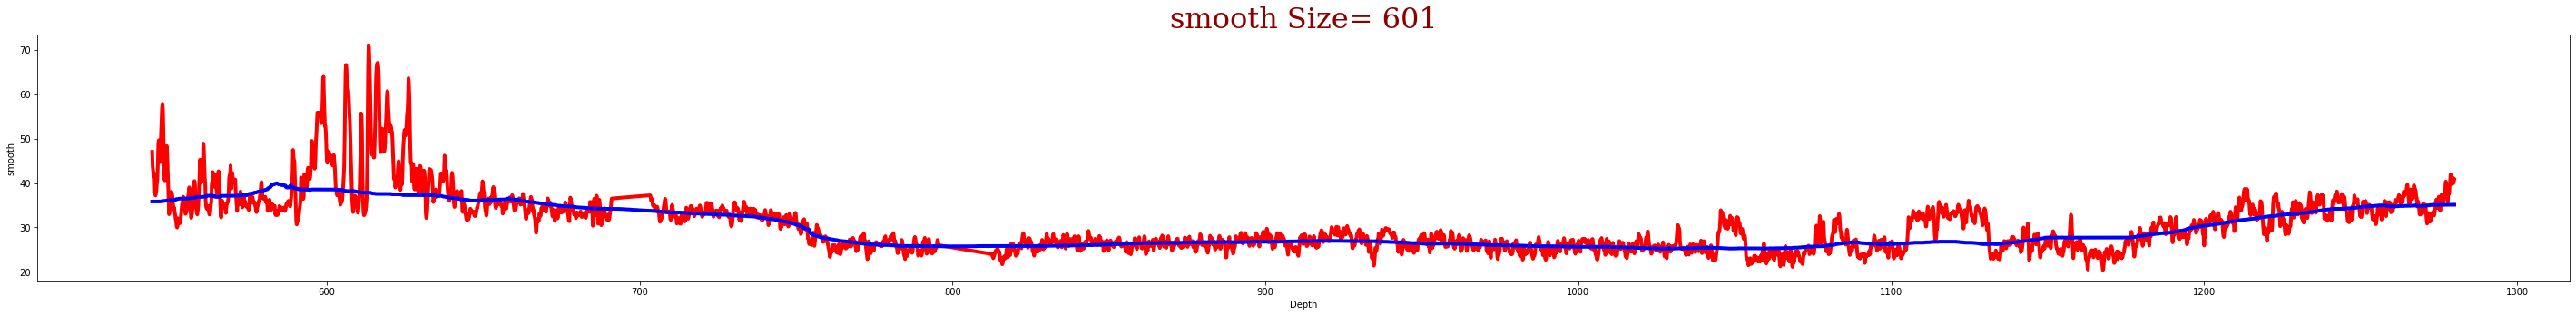

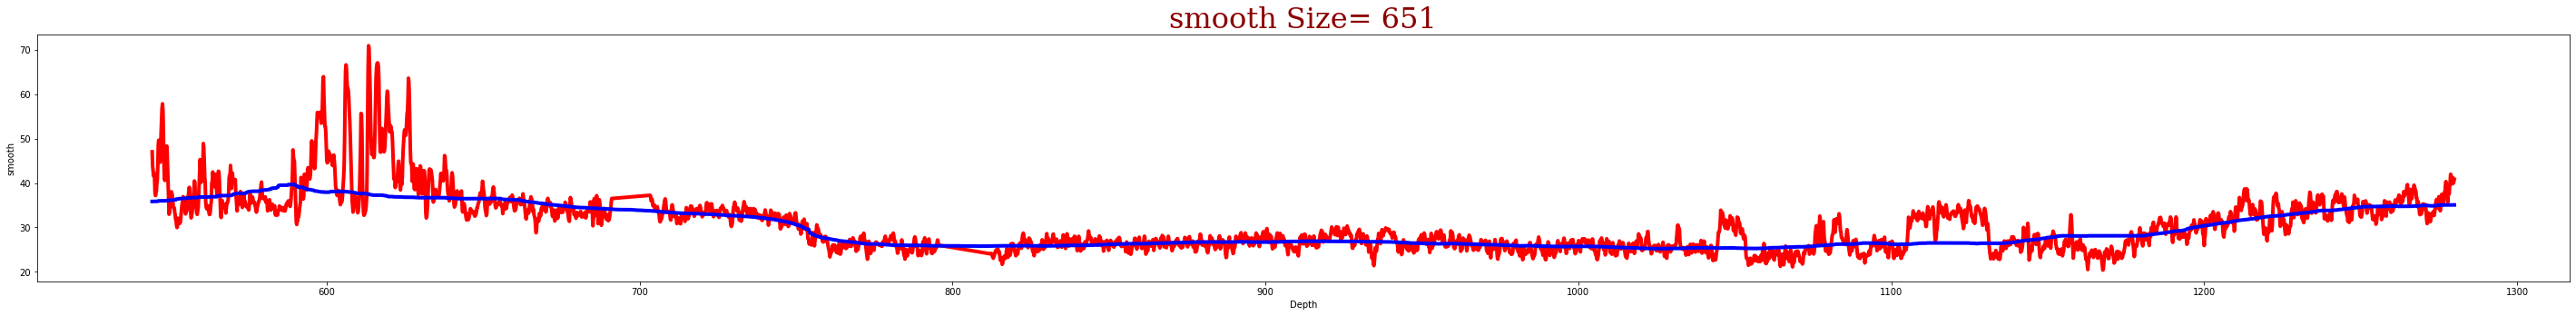

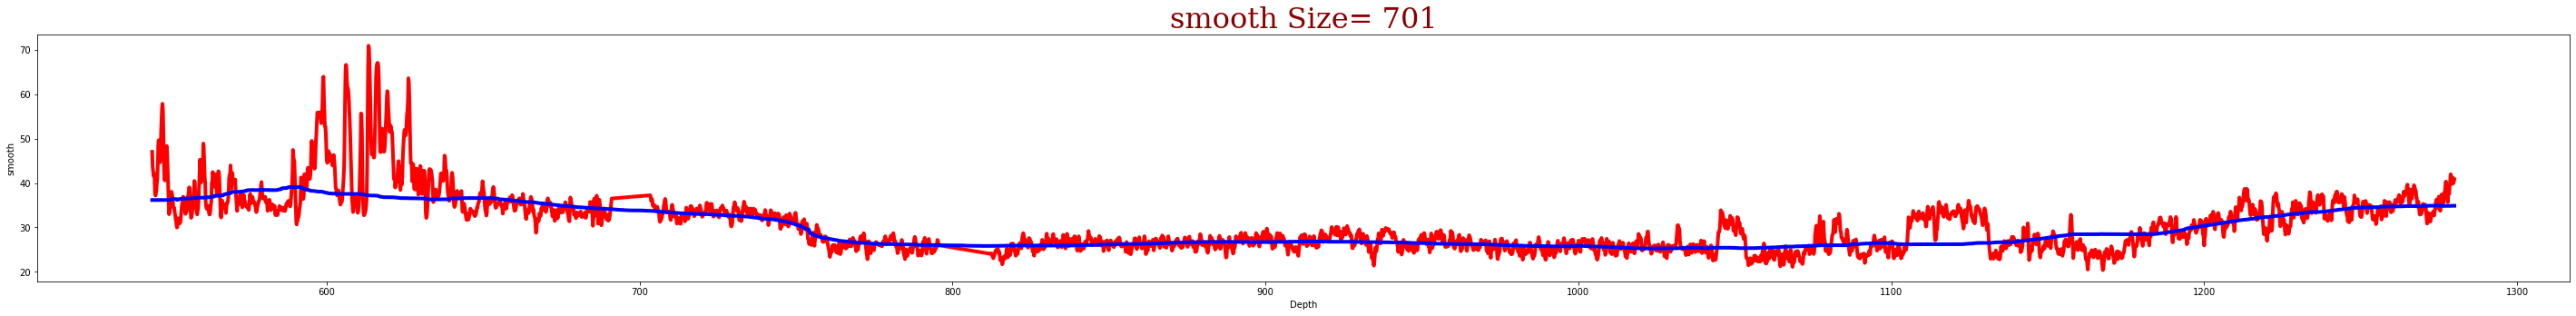

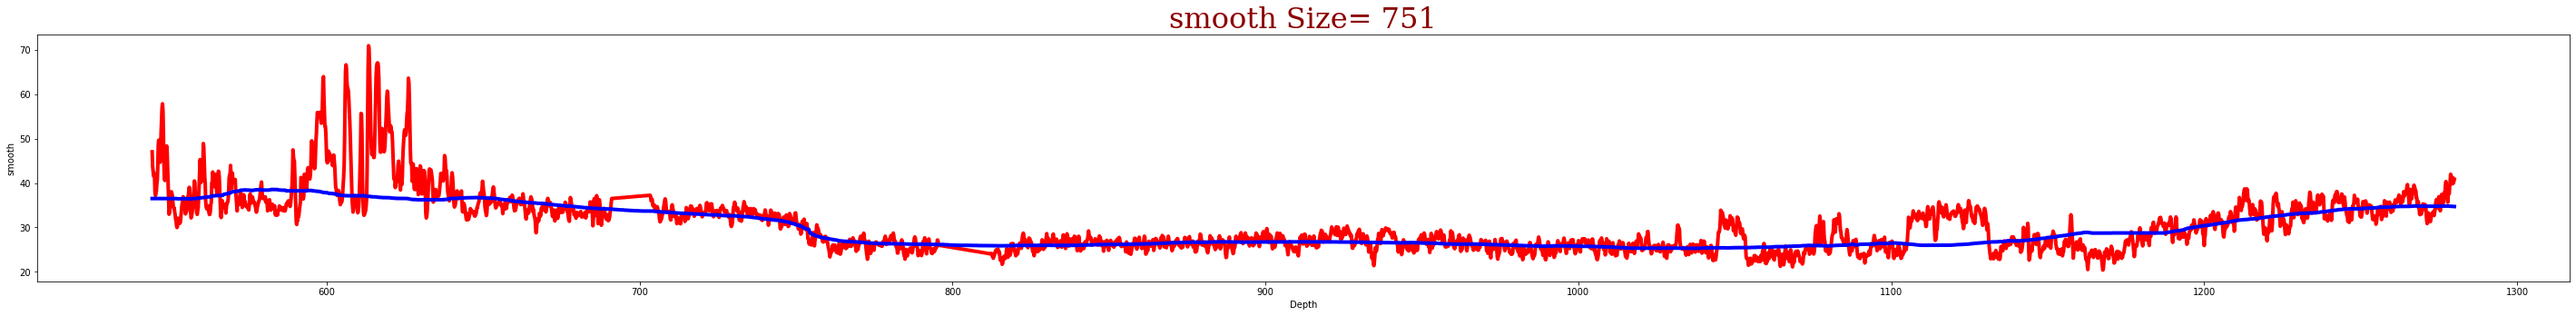

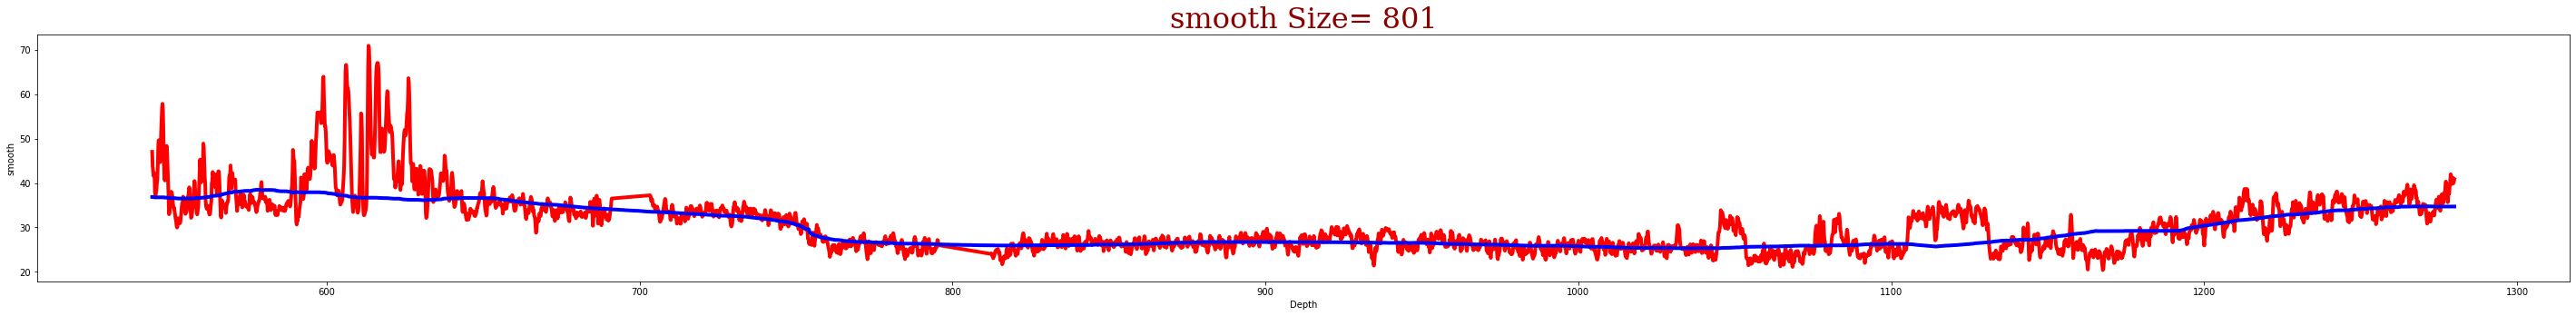

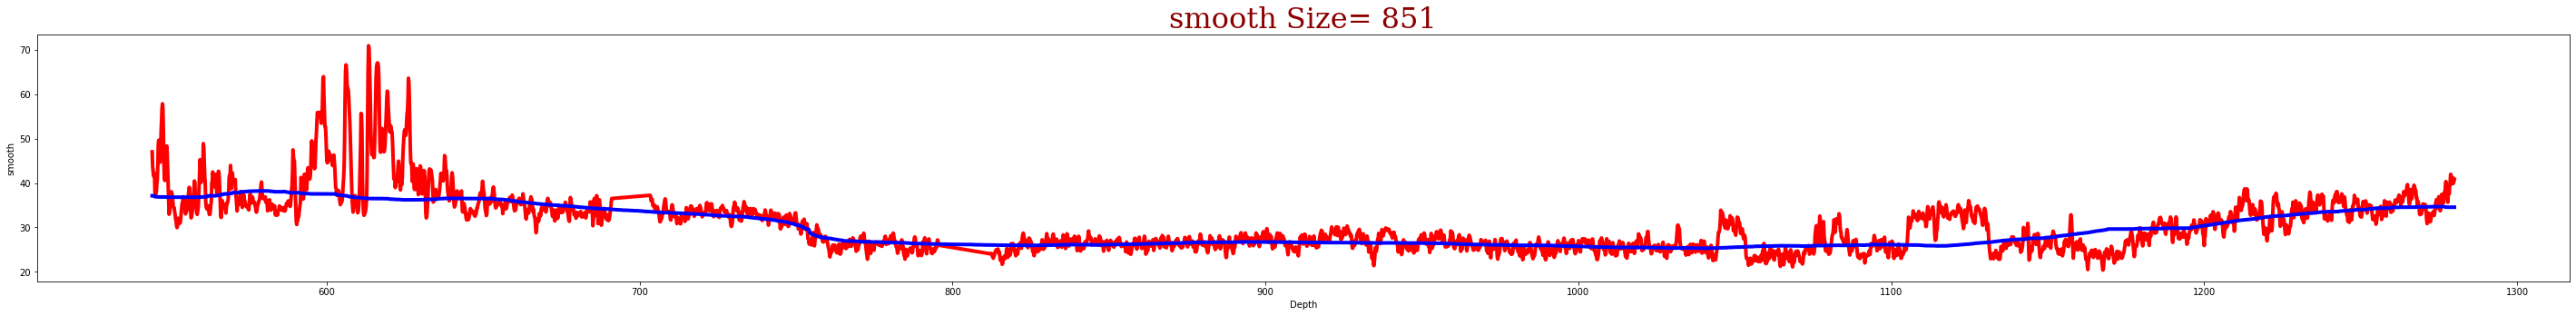

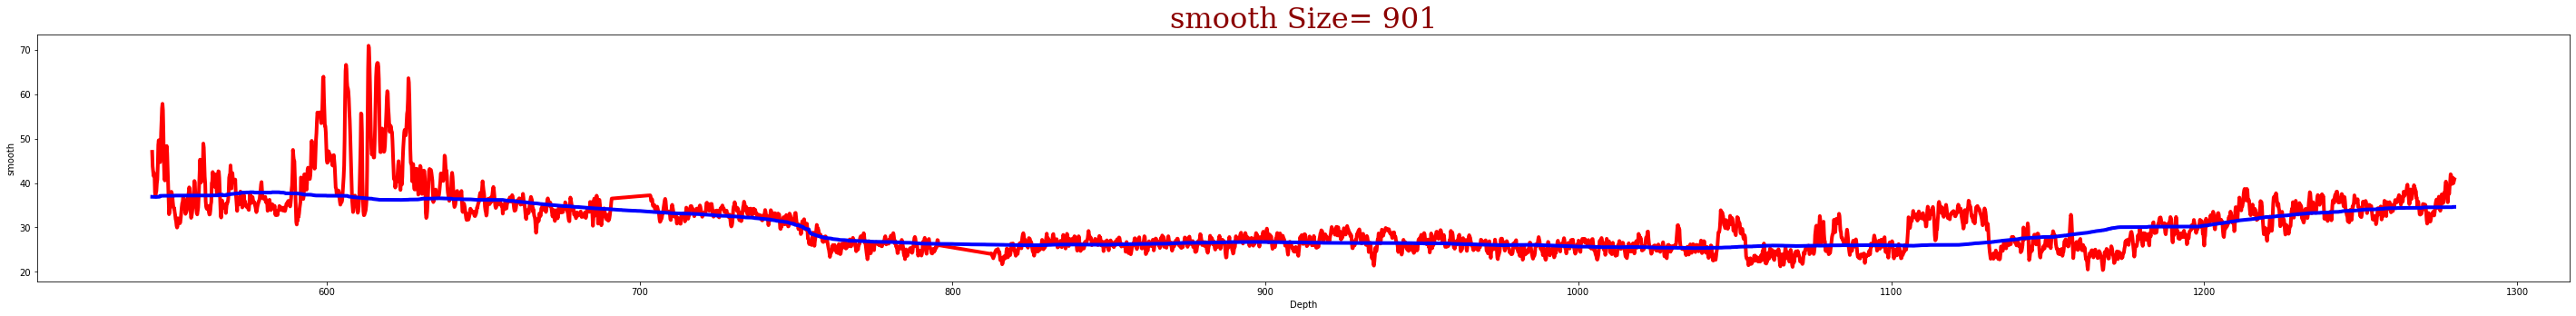

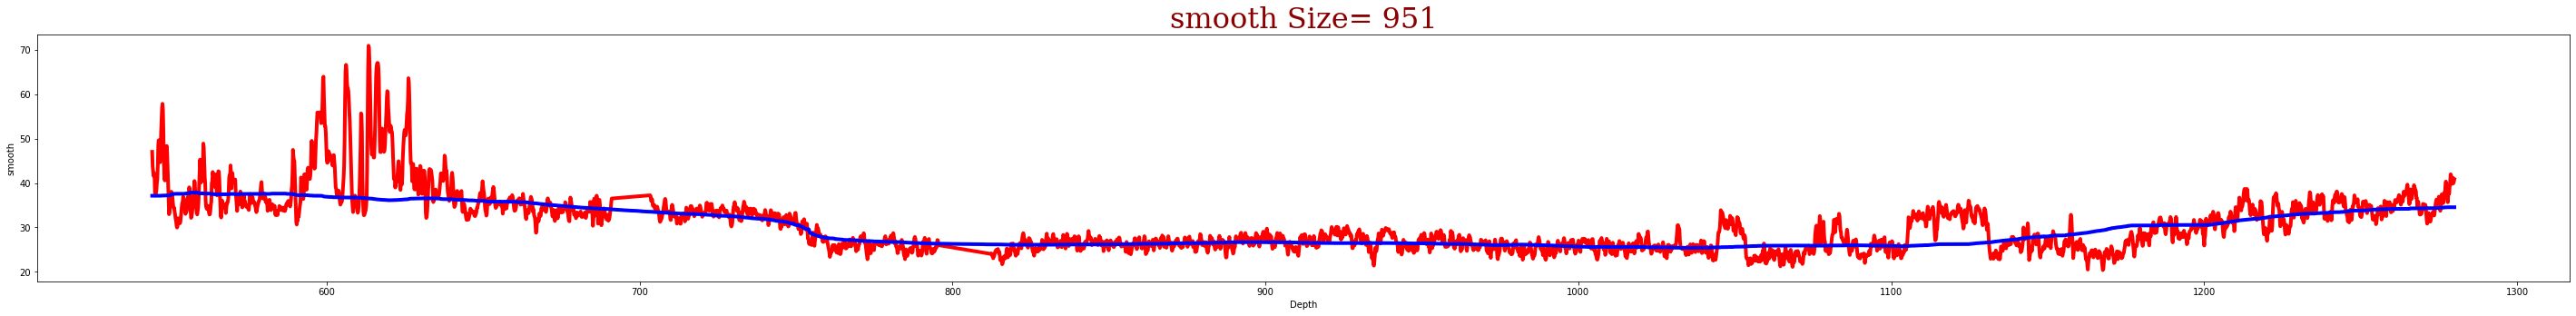

In [219]:
from scipy import ndimage
for i in range(1,1000,50):
    smooth = ndimage.median_filter(X2df['yPorosity'], size = i)
    
    
    print("size", i,", the equavlant Average = ", np.mean(smooth) )
   
    plt.figure(figsize=(50,5))
    plt.plot(X2df['Depth'], X2df['yPorosity'], 'r', linewidth=4.0, label="yPorosity")
    plt.plot(X2df['Depth'], smooth, 'b', linewidth=4.0, label=i )
    plt.xlabel("Depth")
    plt.ylabel("smooth")
    plt.title("smooth Size= " + str(i), fontdict= font)

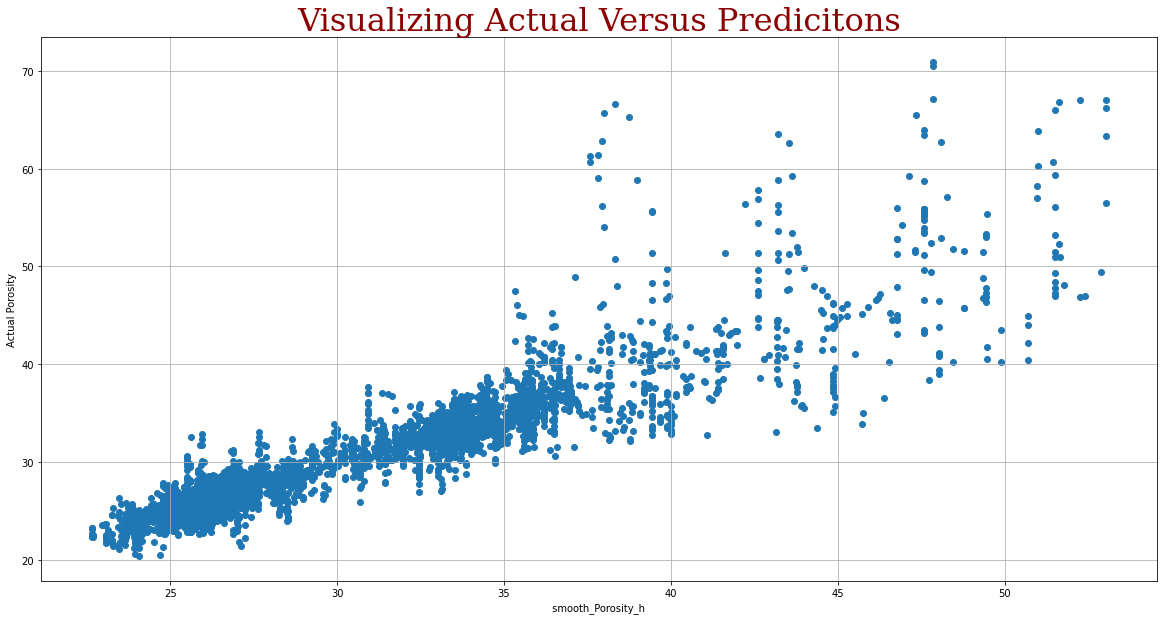

In [220]:
MF_Porosity_50 = ndimage.median_filter(X2df['yPorosity'], size = 50)
#@title Plotting Actual versus Predicted 

plt.figure(figsize=(20,10))
plt.scatter(MF_Porosity_50, X2df['yPorosity'])
plt.xlabel(" smooth_Porosity_h ")
plt.ylabel("Actual Porosity")
plt.title("Visualizing Actual Versus Predicitons", fontdict= font)
plt.grid()

In [221]:
X2df.describe()

Amp       D1        D2  ...  pPorosity  yPorosity   Depth
count  4906.00  4906.00   4906.00  ...    4906.00    4906.00 4906.00
mean    -12.43     6.01    -19.11  ...      30.44      30.45  912.08
std     817.21  2353.09   3298.36  ...       6.08       6.43  212.46
min   -2888.46 -8854.79 -14944.56  ...      21.87      20.39  544.20
25%    -507.95 -1139.88  -1771.26  ...      25.94      25.79  728.14
50%     -13.52     7.08    -41.36  ...      28.18      28.30  912.08
75%     464.96  1105.53   1795.25  ...      33.97      33.98 1096.01
max    2759.31 11384.03  13955.13  ...      63.49      70.90 1279.95

[8 rows x 12 columns]

In [222]:
smooth_df = X2df[['Amplitude', 'D1', 'D2', 'ENV', 'Var', 'WN','Phase']]
y3 = MF_Porosity_50

KeyError: ignored

In [ ]:
#@title Train test split 25%
X3_train, X3_test, y3_train, y3_test = train_test_split(smooth_df, y3, test_size=0.25, random_state=101)
print(X3_train.shape)
print(y3_train.shape)

In [ ]:
#@title Building the random forest model
Rfr_sm = RandomForestRegressor(n_estimators=270,
                            min_samples_leaf=10,
                            max_features=6,
                            n_jobs=-1,oob_score=True)
Rfr_sm.fit(X3_train,y3_train)
Rfr_sm.score(X3_test,y3_test)

In [ ]:
#@title OOB score
print('OOB Score:',Rfr_sm.oob_score_)

In [ ]:
%%time
#@title Estimating Errors

y3_pred=Rfr_sm.predict(X3_test)
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y3_test, y3_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y3_test, y3_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y3_test, y3_pred)))

In [ ]:
%%time
#@title Plotting Actual versus Predicted 

plt.figure(figsize=(20,10))
plt.scatter(y3_pred, y3_test)
plt.xlabel(" Predicted Values (y_pred)")
plt.ylabel("Actual Values (y_test)")
plt.title("Visualizing Actual Versus Predicitons")
plt.grid()

In [ ]:
sm_pPorosity =Rfr_sm.predict(smooth_df)

In [ ]:
%%time
#@title Plotting Actual versus Predicted 

plt.figure(figsize=(20,10))
#plt.scatter(MF_Porosity_50, X2df['sm_pPorosity'])
plt.scatter(MF_Porosity_50, sm_pPorosity)
plt.xlabel(" Predicted Values (y_pred)")
plt.ylabel("Actual Values (y_test)")
plt.title("Visualizing Actual Versus Predicitons")
plt.grid()

In [ ]:
plt.figure(figsize=(50,5))
plt.plot(X2df['Depth'], MF_Porosity_50, 'r', linewidth=4.0, label="yPorosity")
plt.plot(X2df['Depth'], sm_pPorosity, 'b', linewidth=4.0, label="smoothed pPorosity" )
plt.xlabel("Depth", fontdict= font)
plt.ylabel("smooth", fontdict= font)
plt.title("smoothed Porosity ", fontdict= font)

In [ ]:
Predicted_SM_Porosity_Cube = Rfr_sm.predict(dataframe)

In [ ]:
Predicted_SM_Porosity_Cube2 = Predicted_Porosity_Cube.reshape(855, 256, 401)

In [ ]:
plt.figure(figsize=(30, 10))
plt.imshow(Predicted_SM_Porosity_Cube2[200].T, cmap='viridis',
           extent=(xl[0], xl[-1], t[-1], t[0]))
plt.title('Porosity data')
plt.colorbar()
plt.axis('tight')

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# Random Forest 
Rf_scaler = make_pipeline(StandardScaler(),
                          RandomForestRegressor(n_estimators=100,
                            min_samples_leaf=3,
                            max_features='auto',
                            n_jobs=-1,oob_score=True)).fit(X2_train,y2_train)
print('Random Forest Score:',Rf_scaler.score(X2_test,y2_test))
#print('RF OOB Score:',Rf_scaler.oob_score_)

In [ ]:
PP_MF_Sc = Rf_scaler.predict(dataframe)

In [ ]:
PP_MF_Sc = PP_MF_Sc.reshape(855, 256, 401)

In [ ]:
plt.figure(figsize=(30, 10))
plt.imshow(PP_MF_Sc[200].T, cmap='viridis',
           extent=(xl[0], xl[-1], t[-1], t[0]))
plt.title('Porosity data')
plt.colorbar()
plt.axis('tight')

In [ ]:
import sys
sys.path.append('./d2geo/attributes')

import h5py
from shutil import copyfile as cf
from d2geo.attributes.io import segy_read, segy_write
output = segy_write(PP_MF_Sc, segyfile, "PP_MF_Sc_3.segy")

In [ ]:
Rf_scaler